In [3]:
import sys
# sys.path.append('/home/rat884/code/ipy_notebooks/spend_cbg_analysis')
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns
import ast
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import helper_functions as hf
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import binom
import holidays
from scipy.stats import ttest_1samp, ttest_ind
import multiprocessing as mp
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from statsmodels.tools import add_constant
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from scipy.stats import mannwhitneyu, wilcoxon, median_test, mood
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap

In [5]:
# Change this to where the figures are to be saved
fig_path = "/home/rat884/code/heat_cold_asymmetry/figures"

In [6]:
# Read all spend effects between 2019-2023
years = [2019,2020,2021,2022,2023]
path_ee_spend = "/home/rat884/code/heat_cold_asymmetry/data/extreme_events/spend/extreme_events/"
ee_spend_list = []
for yr in years:
    ee_params_spend_yr = pd.read_csv(os.path.join(path_ee_spend, f"ee_params_df_{yr}.csv"), index_col=0, dtype={'census_tract':str}, parse_dates=["event_date"])
    ee_params_spend_yr["year"] = yr
    ee_spend_list.append(ee_params_spend_yr)
ee_params_spend_all = pd.concat(ee_spend_list, axis=0)
ee_params_spend_all.reset_index(drop=True,inplace=True)
ee_params_spend_all["ee_ratio_std"] = ee_params_spend_all["resid"]/ee_params_spend_all["std"]


In [7]:
# Read all mobility effects between 2019-2023
years = [2019,2020,2021,2022,2023]
path_ee_mobility = "/home/rat884/code/heat_cold_asymmetry/data/extreme_events/footfall/extreme_events"
ee_mobility_list = []
for yr in years:
    ee_params_mobility_yr = pd.read_csv(os.path.join(path_ee_mobility, f"ee_params_df_{yr}.csv"), index_col=0, dtype={'census_tract':str}, parse_dates=["event_date"])
    ee_params_mobility_yr["year"] = yr
    ee_mobility_list.append(ee_params_mobility_yr)
ee_params_mobility_all = pd.concat(ee_mobility_list, axis=0)
ee_params_mobility_all.reset_index(drop=True,inplace=True)
ee_params_mobility_all["ee_ratio_std"] = ee_params_mobility_all["resid"]/ee_params_mobility_all["std"] 
# ee_params_mobility_all["month"] = ee_params_spend_all["event_date"].apply(lambda x: x.month)
# ee_params_mobility_all["weekday"] = ee_params_spend_all["event_date"].apply(lambda x: x.weekday())

In [8]:
# Mobility 2019 baseline
ee_params_mobility_2019 = ee_params_mobility_all[ee_params_mobility_all['year']==2019]
y_2019 = ee_params_mobility_2019.groupby('census_tract')['mean'].mean()
ee_params_mobility_all['Y_2019'] = ee_params_mobility_all['census_tract'].map(y_2019)
ee_params_mobility_all_2019 = ee_params_mobility_all.dropna(subset='Y_2019')
ee_params_mobility_all_2019['ee_ratio_2019'] = ee_params_mobility_all_2019['resid']/ee_params_mobility_all_2019['Y_2019']

# Spend 2019 baseline
ee_params_spend_2019 = ee_params_spend_all[ee_params_spend_all['year']==2019]
y_2019 = ee_params_spend_2019.groupby('census_tract')['mean'].mean()
ee_params_spend_all['Y_2019'] = ee_params_spend_all['census_tract'].map(y_2019)
ee_params_spend_all_2019 = ee_params_spend_all.dropna(subset='Y_2019')
ee_params_spend_all_2019['ee_ratio_2019'] = ee_params_spend_all_2019['resid']/ee_params_spend_all_2019['Y_2019']



/tmp/ipykernel_2643288/1633537416.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ee_params_mobility_all_2019['ee_ratio_2019'] = ee_params_mobility_all_2019['resid']/ee_params_mobility_all_2019['Y_2019']
/tmp/ipykernel_2643288/1633537416.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ee_params_spend_all_2019['ee_ratio_2019'] = ee_params_spend_all_2019['resid']/ee_params_spend_all_2019['Y_2019']


In [9]:


def resample_ee_params_vectorized(ee_params, n, col):
    """Vectorized version using NumPy operations"""
    # Pre-compute grouping indices
    year_groups = ee_params.groupby(["event_type", "year"]).groups
    overall_groups = ee_params.groupby(["event_type"]).groups
    
    # Convert to arrays for faster indexing
    ee_ratio_values = ee_params[col].values
    n_rows = len(ee_params)
    
    # Pre-allocate results
    error_year_list = []
    error_overall_list = []
    
    # Generate all random indices at once
    np.random.seed(42)  # For reproducibility
    random_indices = np.random.randint(0, n_rows, size=(n, n_rows))
    
    for i in range(n):
        if i % 100 == 0:
            print(i)
            
        # Get resampled indices
        sample_indices = random_indices[i]
        
        # Create resampled dataframe (only when needed)
        resampled_df = ee_params.iloc[sample_indices]
        
        # Compute medians
        year_median = resampled_df.groupby(["event_type", "year"])[col].median().reset_index()
        overall_median = resampled_df.groupby(["event_type"])[col].median().reset_index()
        
        error_year_list.append(year_median)
        error_overall_list.append(overall_median)
    
    return error_year_list, error_overall_list

In [10]:
# Column name in data that has the EE effects
col = "ee_ratio"

In [11]:
# Extreme event effects (by event type) across years
ee_params_spend_all.groupby(['year','event_type'])['ee_ratio'].median()

year  event_type        
2019  Extreme Cold Event    0.005726
      Extreme Heat Event   -0.019029
2020  Extreme Cold Event   -0.040875
      Extreme Heat Event   -0.029640
2021  Extreme Cold Event   -0.050445
      Extreme Heat Event   -0.036244
2022  Extreme Cold Event   -0.053293
      Extreme Heat Event   -0.028326
2023  Extreme Cold Event   -0.039673
      Extreme Heat Event   -0.029087
Name: ee_ratio, dtype: float64

In [12]:
# Resample Extreme Event effects to compute the uncertainty in the overall effect size data
error_year_list_spend, error_overall_list_spend = resample_ee_params_vectorized(ee_params_spend_all, 100, col)
error_year_list_mobility, error_overall_list_mobility = resample_ee_params_vectorized(ee_params_mobility_all,100, col)

0
0


In [13]:
# Resample Extreme Event effects to compute the uncertainty in the overall effect size data using 2019 as the baseline
error_year_list_spend_2019, error_overall_list_spend_2019 = resample_ee_params_vectorized(ee_params_spend_all_2019, 100, col)
error_year_list_mobility_2019, error_overall_list_mobility_2019 = resample_ee_params_vectorized(ee_params_mobility_all_2019,100, col)

0
0


In [14]:
# Spend
ee_params_year_025_spend = pd.concat(error_year_list_spend, axis=0).groupby(["event_type", "year"])[col].quantile(0.025)
ee_params_year_975_spend = pd.concat(error_year_list_spend, axis=0).groupby(["event_type", "year"])[col].quantile(1-0.025)
ee_params_overall_025_spend = pd.concat(error_overall_list_spend, axis=0).groupby(["event_type"])[col].quantile(0.025)
ee_params_overall_975_spend = pd.concat(error_overall_list_spend, axis=0).groupby(["event_type"])[col].quantile(1-0.025)

# Mobility
ee_params_year_025_mobility = pd.concat(error_year_list_mobility, axis=0).groupby(["event_type", "year"])[col].quantile(0.025)
ee_params_year_975_mobility = pd.concat(error_year_list_mobility, axis=0).groupby(["event_type", "year"])[col].quantile(1-0.025)
ee_params_overall_025_mobility = pd.concat(error_overall_list_mobility, axis=0).groupby(["event_type"])[col].quantile(0.025)
ee_params_overall_975_mobility = pd.concat(error_overall_list_mobility, axis=0).groupby(["event_type"])[col].quantile(1-0.025)

In [15]:
# Spend for 2019 baseline
ee_params_year_025_spend_2019 = pd.concat(error_year_list_spend_2019, axis=0).groupby(["event_type", "year"])[col].quantile(0.025)
ee_params_year_975_spend_2019 = pd.concat(error_year_list_spend_2019, axis=0).groupby(["event_type", "year"])[col].quantile(1-0.025)
ee_params_overall_025_spend_2019 = pd.concat(error_overall_list_spend_2019, axis=0).groupby(["event_type"])[col].quantile(0.025)
ee_params_overall_975_spend_2019 = pd.concat(error_overall_list_spend_2019, axis=0).groupby(["event_type"])[col].quantile(1-0.025)

# Mobility for 2019 baseline
ee_params_year_025_mobility_2019 = pd.concat(error_year_list_mobility_2019, axis=0).groupby(["event_type", "year"])[col].quantile(0.025)
ee_params_year_975_mobility_2019 = pd.concat(error_year_list_mobility_2019, axis=0).groupby(["event_type", "year"])[col].quantile(1-0.025)
ee_params_overall_025_mobility_2019 = pd.concat(error_overall_list_mobility_2019, axis=0).groupby(["event_type"])[col].quantile(0.025)
ee_params_overall_975_mobility_2019 = pd.concat(error_overall_list_mobility_2019, axis=0).groupby(["event_type"])[col].quantile(1-0.025)

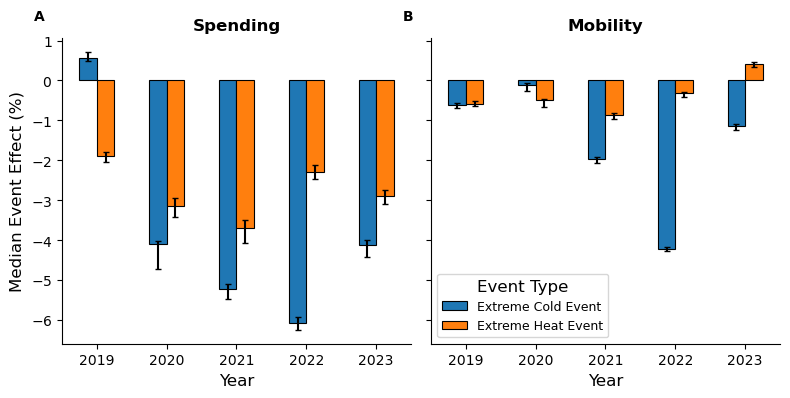

In [18]:
capsize = 2
fontsize = 12

# # Define colors for the bars
# colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']  # Custom color palette
# colors = sns.color_palette("husl", 4)
# # Matplotlib built-in palettes
# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
# # Professional color scheme
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
# Colorbrewer palette
# colors = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072']

# Viridis-like
# from matplotlib.cm import viridis
# colors = viridis(np.linspace(0, 1, 4))
# Alternative: colors = plt.cm.Set2(np.linspace(0, 1, 4))  # Using colormap

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# SPEND
bar_data_spend = ee_params_spend_all_2019.groupby(["event_type","year"])[col].median().reset_index()
bar_data_spend[col] *= 100

bar_data_mobility = ee_params_mobility_all_2019.groupby(["event_type","year"])[col].median().reset_index()
bar_data_mobility[col] *= 100

bar_plot_spend_025 = ee_params_year_025_spend_2019.reset_index().pivot(index="year", columns="event_type")[col]*100
bar_plot_spend_975 = ee_params_year_975_spend_2019.reset_index().pivot(index="year", columns="event_type")[col]*100

# Pivot your data for easier plotting
df_pivot_spend = bar_data_spend.pivot(index='year', columns='event_type', values=col).sort_index()

# Calculate error arrays (fix the transpose issue)
yerr_lower_spend = df_pivot_spend - bar_plot_spend_025
yerr_upper_spend = bar_plot_spend_975 - df_pivot_spend
yerr_spend = np.array([yerr_lower_spend.values.T, yerr_upper_spend.values.T])

# Plot with styling
df_pivot_spend.plot(kind='bar', 
                   yerr=yerr_spend, 
                   capsize=capsize, 
                   ax=ax[0],
                   color=colors[:len(df_pivot_spend.columns)],  # Set custom colors
                   edgecolor='black',      # Bar outline color
                   linewidth=0.8)          # Bar outline thickness

# MOBILITY
bar_plot_mobility_025 = ee_params_year_025_mobility_2019.reset_index().pivot(index="year", columns="event_type")[col]*100
bar_plot_mobility_975 = ee_params_year_975_mobility_2019.reset_index().pivot(index="year", columns="event_type")[col]*100

# Pivot your data for easier plotting
df_pivot_mobility = bar_data_mobility.pivot(index='year', columns='event_type', values=col).sort_index()

# Calculate error arrays (fix the transpose issue)
yerr_lower_mobility = df_pivot_mobility - bar_plot_mobility_025
yerr_upper_mobility = bar_plot_mobility_975 - df_pivot_mobility
yerr_mobility = np.array([yerr_lower_mobility.values.T, yerr_upper_mobility.values.T])

# Plot with styling
df_pivot_mobility.plot(kind='bar', 
                      yerr=yerr_mobility, 
                      capsize=capsize, 
                      ax=ax[1],
                      color=colors[:len(df_pivot_mobility.columns)],  # Set custom colors
                      edgecolor='black',     # Bar outline color
                      linewidth=0.8)         # Bar outline thickness

# STYLING CUSTOMIZATIONS

# 1. Rotate x-axis labels to horizontal
ax[0].tick_params(axis='x', rotation=0, labelsize=fontsize-2)
ax[1].tick_params(axis='x', rotation=0, labelsize=fontsize-2)

# 2. Set font size for axis labels
ax[0].tick_params(axis='y', labelsize=fontsize-2)
ax[1].tick_params(axis='y', labelsize=fontsize-2)

# Set axis label fonts
ax[0].set_xlabel('Year', fontsize=fontsize)
ax[0].set_ylabel('Median Event Effect (%)', fontsize=fontsize)
ax[1].set_xlabel('Year', fontsize=fontsize)

# 3. Show legend only for the first subplot
ax[1].legend(title='Event Type', fontsize=fontsize-3, title_fontsize=fontsize, loc="best")
ax[0].legend().set_visible(False)  # Hide legend for second subplot

# 4. Remove top and right spines
for axis in [ax[0], ax[1]]:
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    
    # Optional: make left and bottom spines thinner
    axis.spines['left'].set_linewidth(0.8)
    axis.spines['bottom'].set_linewidth(0.8)
    axis.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)


# Add subplot titles
ax[0].set_title('Spending', fontsize=fontsize, fontweight='bold')
ax[1].set_title('Mobility', fontsize=fontsize, fontweight='bold')

plt.tight_layout()
panel_labels = ['A', 'B']
panels = [ax[0], ax[1]]  # Clockwise: top-left, top-right, bottom-right, bottom-left

for label, panel in zip(panel_labels, panels):
    panel.text(-0.05, 1.05, label, transform=panel.transAxes, 
              fontsize=10, fontweight='bold', va='bottom', ha='right')

fig.savefig(os.path.join(fig_path, "ee_effects_barplot_y_2019_baseline.png"), dpi=300)

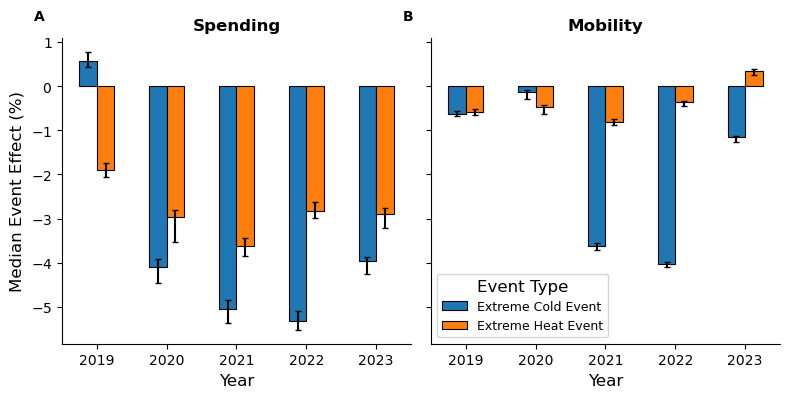

In [19]:
capsize = 2
fontsize = 12

# # Define colors for the bars
# colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']  # Custom color palette
# colors = sns.color_palette("husl", 4)
# # Matplotlib built-in palettes
# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
# # Professional color scheme
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
# Colorbrewer palette
# colors = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072']

# Viridis-like
# from matplotlib.cm import viridis
# colors = viridis(np.linspace(0, 1, 4))
# Alternative: colors = plt.cm.Set2(np.linspace(0, 1, 4))  # Using colormap

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# SPEND
bar_data_spend = ee_params_spend_all.groupby(["event_type","year"])[col].median().reset_index()
bar_data_spend[col] *= 100

bar_data_mobility = ee_params_mobility_all.groupby(["event_type","year"])[col].median().reset_index()
bar_data_mobility[col] *= 100

bar_plot_spend_025 = ee_params_year_025_spend.reset_index().pivot(index="year", columns="event_type")[col]*100
bar_plot_spend_975 = ee_params_year_975_spend.reset_index().pivot(index="year", columns="event_type")[col]*100

# Pivot your data for easier plotting
df_pivot_spend = bar_data_spend.pivot(index='year', columns='event_type', values=col).sort_index()

# Calculate error arrays (fix the transpose issue)
yerr_lower_spend = df_pivot_spend - bar_plot_spend_025
yerr_upper_spend = bar_plot_spend_975 - df_pivot_spend
yerr_spend = np.array([yerr_lower_spend.values.T, yerr_upper_spend.values.T])

# Plot with styling
df_pivot_spend.plot(kind='bar', 
                   yerr=yerr_spend, 
                   capsize=capsize, 
                   ax=ax[0],
                   color=colors[:len(df_pivot_spend.columns)],  # Set custom colors
                   edgecolor='black',      # Bar outline color
                   linewidth=0.8)          # Bar outline thickness

# MOBILITY
bar_plot_mobility_025 = ee_params_year_025_mobility.reset_index().pivot(index="year", columns="event_type")[col]*100
bar_plot_mobility_975 = ee_params_year_975_mobility.reset_index().pivot(index="year", columns="event_type")[col]*100

# Pivot your data for easier plotting
df_pivot_mobility = bar_data_mobility.pivot(index='year', columns='event_type', values=col).sort_index()

# Calculate error arrays (fix the transpose issue)
yerr_lower_mobility = df_pivot_mobility - bar_plot_mobility_025
yerr_upper_mobility = bar_plot_mobility_975 - df_pivot_mobility
yerr_mobility = np.array([yerr_lower_mobility.values.T, yerr_upper_mobility.values.T])

# Plot with styling
df_pivot_mobility.plot(kind='bar', 
                      yerr=yerr_mobility, 
                      capsize=capsize, 
                      ax=ax[1],
                      color=colors[:len(df_pivot_mobility.columns)],  # Set custom colors
                      edgecolor='black',     # Bar outline color
                      linewidth=0.8)         # Bar outline thickness

# STYLING CUSTOMIZATIONS

# 1. Rotate x-axis labels to horizontal
ax[0].tick_params(axis='x', rotation=0, labelsize=fontsize-2)
ax[1].tick_params(axis='x', rotation=0, labelsize=fontsize-2)

# 2. Set font size for axis labels
ax[0].tick_params(axis='y', labelsize=fontsize-2)
ax[1].tick_params(axis='y', labelsize=fontsize-2)

# Set axis label fonts
ax[0].set_xlabel('Year', fontsize=fontsize)
ax[0].set_ylabel('Median Event Effect (%)', fontsize=fontsize)
ax[1].set_xlabel('Year', fontsize=fontsize)

# 3. Show legend only for the first subplot
ax[1].legend(title='Event Type', fontsize=fontsize-3, title_fontsize=fontsize, loc="best")
ax[0].legend().set_visible(False)  # Hide legend for second subplot

# 4. Remove top and right spines
for axis in [ax[0], ax[1]]:
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    
    # Optional: make left and bottom spines thinner
    axis.spines['left'].set_linewidth(0.8)
    axis.spines['bottom'].set_linewidth(0.8)
    axis.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)


# Add subplot titles
ax[0].set_title('Spending', fontsize=fontsize, fontweight='bold')
ax[1].set_title('Mobility', fontsize=fontsize, fontweight='bold')

plt.tight_layout()
panel_labels = ['A', 'B']
panels = [ax[0], ax[1]]  # Clockwise: top-left, top-right, bottom-right, bottom-left

for label, panel in zip(panel_labels, panels):
    panel.text(-0.05, 1.05, label, transform=panel.transAxes, 
              fontsize=10, fontweight='bold', va='bottom', ha='right')

fig.savefig(os.path.join(fig_path, "ee_effects_barplot.png"), dpi=300)

In [20]:
stats_mob = ee_params_mobility_all.groupby(['event_type'])['ee_ratio'].agg(['mean', 'std', 'count'])
stats_spend = ee_params_spend_all.groupby(['event_type'])['ee_ratio'].agg(['mean', 'std', 'count'])

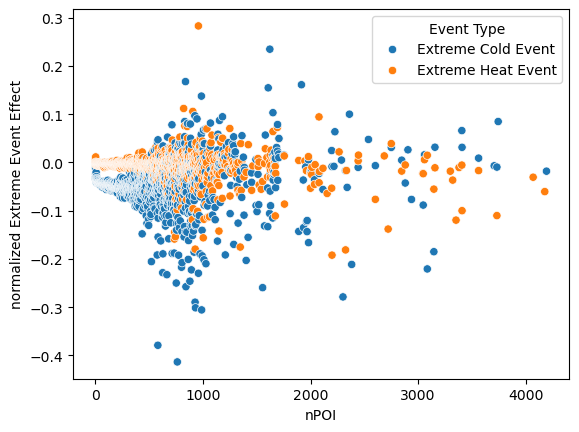

In [22]:
# Extreme Heat and Cold effects versus number of PoIs in the Census Tract

loss_poi = ee_params_mobility_all.groupby(["row_count_01", "event_type"])["ee_ratio"].mean()
loss_poi = loss_poi.reset_index()
# loss_poi
sns.scatterplot(loss_poi, x="row_count_01", y="ee_ratio", hue="event_type")
plt.xlabel('nPOI')
plt.ylabel('normalized Extreme Event Effect')
plt.legend(title='Event Type')
plt.savefig(os.path.join(fig_path, "ee_effects_vs_nPOI.png"), dpi=300)

# loss_poi
# plt.scatter(loss_poi.index, loss_poi)
# plt.xlim([0,1000])

# EE ratio with nPOI

In [23]:
# Threshold for number of POIs above a certain percentile
cutoff_percentile = 0.995
spend_cutoff = int(ee_params_spend_all["row_count_01"].quantile(cutoff_percentile))
mobility_cutoff = int(ee_params_mobility_all["row_count_01"].quantile(cutoff_percentile))
spend_cutoff, mobility_cutoff

(78, 696)

'\n# Professional color scheme\ncolors = [\'#D32F2F\', \'#1976D2\']  # Material Design Red/Blue\n\n# Colorbrewer scheme\ncolors = [\'#e41a1c\', \'#377eb8\']  # Set1 Red/Blue\n\n# Seaborn default\ncolors = sns.color_palette("husl", 2)\n\n# Warm/Cool contrast\ncolors = [\'#FF6B35\', \'#004E98\']  # Orange/Navy\n\n# High contrast\ncolors = [\'#FF4081\', \'#00BCD4\']  # Pink/Cyan\n'

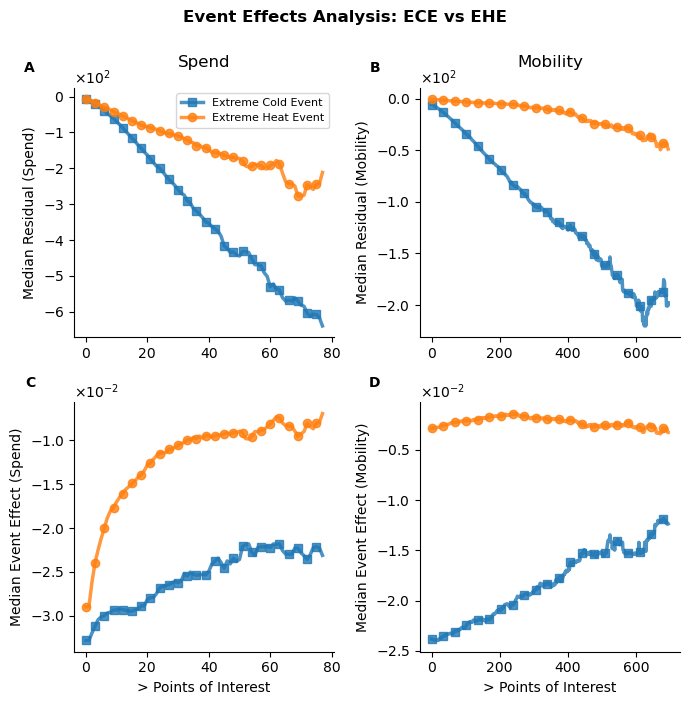

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set style and color palette
plt.style.use('default')
# plt.style.use('seaborn-v0_8-whitegrid')  # Clean, professional style
# colors = ['#E74C3C', '#3498DB']  # Red for heat, Blue for cold
# Professional color scheme
# colors = ['#D32F2F', '#1976D2']  # Material Design Red/Blue
colors = ['#1f77b4', '#ff7f0e'][::-1]
line_styles = ['-', '-']
markers = ['o', 's']

# Calculate cutoffs
cutoff_percentile = 0.995
spend_cutoff = int(ee_params_spend_all["row_count_01"].quantile(cutoff_percentile))
mobility_cutoff = int(ee_params_mobility_all["row_count_01"].quantile(cutoff_percentile))

# Prepare data for spending
ee_spend_ece = ee_params_spend_all[ee_params_spend_all["event_type"]=="Extreme Cold Event"]
ee_spend_ehe = ee_params_spend_all[ee_params_spend_all["event_type"]=="Extreme Heat Event"]
ratio_spend_ece = []
ratio_spend_ehe = []
resid_spend_ece = []
resid_spend_ehe = []

var_resid = "resid"
var_ratio = col

for i_th in range(0, spend_cutoff, 1):
    resid_spend_ece.append(np.median(ee_spend_ece[ee_spend_ece["row_count_01"]>=i_th][var_resid]))
    resid_spend_ehe.append(np.median(ee_spend_ehe[ee_spend_ehe["row_count_01"]>=i_th][var_resid]))
    ratio_spend_ece.append(np.median(ee_spend_ece[ee_spend_ece["row_count_01"]>=i_th][var_ratio]))
    ratio_spend_ehe.append(np.median(ee_spend_ehe[ee_spend_ehe["row_count_01"]>=i_th][var_ratio]))

# Prepare data for mobility
ee_mobility_ece = ee_params_mobility_all[ee_params_mobility_all["event_type"]=="Extreme Cold Event"]
ee_mobility_ehe = ee_params_mobility_all[ee_params_mobility_all["event_type"]=="Extreme Heat Event"]
ratio_mobility_ece = []
ratio_mobility_ehe = []
resid_mobility_ece = []
resid_mobility_ehe = []

for i_th in range(0, mobility_cutoff, 1):
    resid_mobility_ece.append(np.median(ee_mobility_ece[ee_mobility_ece["row_count_01"]>=i_th][var_resid]))
    resid_mobility_ehe.append(np.median(ee_mobility_ehe[ee_mobility_ehe["row_count_01"]>=i_th][var_resid]))
    ratio_mobility_ece.append(np.median(ee_mobility_ece[ee_mobility_ece["row_count_01"]>=i_th][var_ratio]))
    ratio_mobility_ehe.append(np.median(ee_mobility_ehe[ee_mobility_ehe["row_count_01"]>=i_th][var_ratio]))

# Create the figure
fig, ax = plt.subplots(2, 2, figsize=(7, 7), sharex=False, sharey=False)
fig.suptitle('Event Effects Analysis: ECE vs EHE', fontsize=12, fontweight='bold', y=1.0)

# Define consistent styling parameters
fontsize_title = 12
fontsize_label = 10
fontsize_legend = 8
linewidth = 2.5
markersize = 6
alpha = 0.8

# SPENDING COLUMN
# Top left: Spending Event Effect
x_spend = range(0, spend_cutoff, 1)
ax[0,0].plot(x_spend, resid_spend_ece, 
            color=colors[1], linestyle=line_styles[0], marker=markers[1],
            linewidth=linewidth, markersize=markersize, alpha=alpha,
            label="Extreme Cold Event", markevery=max(1, len(x_spend)//20))

ax[0,0].plot(x_spend, resid_spend_ehe, 
            color=colors[0], linestyle=line_styles[1], marker=markers[0],
            linewidth=linewidth, markersize=markersize, alpha=alpha,
            label="Extreme Heat Event", markevery=max(1, len(x_spend)//20))

ax[0,0].set_title("Spend", fontsize=fontsize_title, pad=15)
ax[0,0].set_ylabel("Median Residual (Spend)", fontsize=fontsize_label)
ax[0,0].legend(fontsize=fontsize_legend, loc='best', frameon=True, fancybox=True, shadow=False)
ax[0,0].spines['top'].set_visible(False)
ax[0,0].spines['right'].set_visible(False)

# Bottom left: Spending Ratio
ax[1,0].plot(x_spend, ratio_spend_ece, 
            color=colors[1], linestyle=line_styles[0], marker=markers[1],
            linewidth=linewidth, markersize=markersize, alpha=alpha,
            label="Extreme Cold Event", markevery=max(1, len(x_spend)//20))

ax[1,0].plot(x_spend, ratio_spend_ehe, 
            color=colors[0], linestyle=line_styles[1], marker=markers[0],
            linewidth=linewidth, markersize=markersize, alpha=alpha,
            label="Extreme Heat Event", markevery=max(1, len(x_spend)//20))

# ax[1,0].set_title("Spending: Event Effect/Mean", fontsize=fontsize_title, fontweight='bold', pad=5)
ax[1,0].set_ylabel("Median Event Effect (Spend)", fontsize=fontsize_label)
ax[1,0].set_xlabel("> Points of Interest", fontsize=fontsize_label)
ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['right'].set_visible(False)

# MOBILITY COLUMN
# Top right: Mobility Event Effect
x_mobility = range(0, mobility_cutoff, 1)
ax[0,1].plot(x_mobility, resid_mobility_ece, 
            color=colors[1], linestyle=line_styles[0], marker=markers[1],
            linewidth=linewidth, markersize=markersize, alpha=alpha,
            label="Extreme Cold Event", markevery=max(1, len(x_mobility)//20))

ax[0,1].plot(x_mobility, resid_mobility_ehe, 
            color=colors[0], linestyle=line_styles[1], marker=markers[0],
            linewidth=linewidth, markersize=markersize, alpha=alpha,
            label="Extreme Heat Event", markevery=max(1, len(x_mobility)//20))

ax[0,1].set_title("Mobility", fontsize=fontsize_title, pad=15)
ax[0,1].set_ylabel("Median Residual (Mobility)", fontsize=fontsize_label)
ax[0,1].spines['top'].set_visible(False)
ax[0,1].spines['right'].set_visible(False)

# Bottom right: Mobility Ratio
ax[1,1].plot(x_mobility, ratio_mobility_ece, 
            color=colors[1], linestyle=line_styles[0], marker=markers[1],
            linewidth=linewidth, markersize=markersize, alpha=alpha,
            label="Extreme Cold Event", markevery=max(1, len(x_mobility)//20))

ax[1,1].plot(x_mobility, ratio_mobility_ehe, 
            color=colors[0], linestyle=line_styles[1], marker=markers[0],
            linewidth=linewidth, markersize=markersize, alpha=alpha,
            label="Extreme Heat Event", markevery=max(1, len(x_mobility)//20))

# ax[1,1].set_title("Mobility: Event Effect/Mean", fontsize=fontsize_title, pad=15)
ax[1,1].set_ylabel("Median Event Effect (Mobility)", fontsize=fontsize_label)
ax[1,1].set_xlabel("> Points of Interest", fontsize=fontsize_label)
ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['right'].set_visible(False)

# from matplotlib.ticker import FormatStrFormatter

ax[0,0].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
# ax[0,0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1e}'))
ax[0,1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
ax[1,0].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
ax[1,1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)

# Improve layout
# Add panel labels (A, B, C, D) in clockwise fashion
panel_labels = ['A', 'B', 'C', 'D']
panels = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]  # Clockwise: top-left, top-right, bottom-right, bottom-left

for label, panel in zip(panel_labels, panels):
    panel.text(-0.15, 1.05, label, transform=panel.transAxes, 
              fontsize=fontsize_label, fontweight='bold', va='bottom', ha='right')

plt.tight_layout()
fig.savefig(os.path.join(fig_path, "ee_poi.png"), dpi=300)

"""
# Professional color scheme
colors = ['#D32F2F', '#1976D2']  # Material Design Red/Blue

# Colorbrewer scheme
colors = ['#e41a1c', '#377eb8']  # Set1 Red/Blue

# Seaborn default
colors = sns.color_palette("husl", 2)

# Warm/Cool contrast
colors = ['#FF6B35', '#004E98']  # Orange/Navy

# High contrast
colors = ['#FF4081', '#00BCD4']  # Pink/Cyan
"""

Fraction of ct included for spend
Spend tract days 480440
SKEW
6.237033577881055
8.474356648929762
-0.0381230355139239 -0.018338572634221503
5.223633546975205e-34
Fraction of ct included for mobility
Mobility tract days 568384
SKEW
7.380292618015642
1.2310199536241153
-0.029590751650882235 -0.004566592498476886
0.0


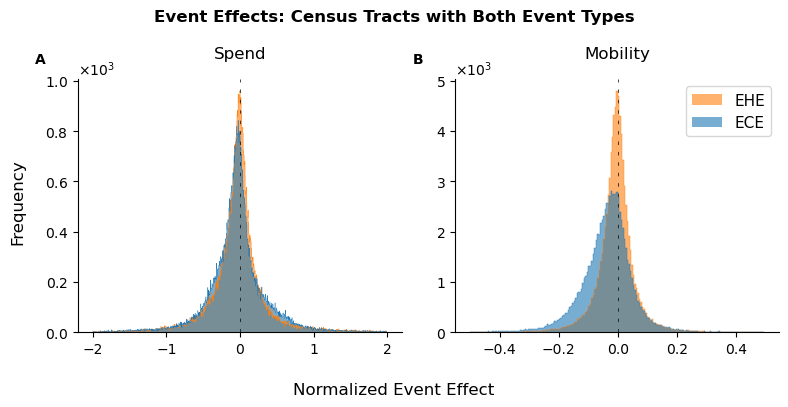

In [25]:
from scipy.stats import skew
import matplotlib.pyplot as plt
import numpy as np

# Create 2x1 subplot
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
capsize = 2
fontsize = 12
fontsize_title = 12
fontsize_label = 10
fontsize_legend = 8
linewidth = 2.5
markersize = 6
alpha = 0.8

# colors
col = "ee_ratio"
colors = ['#ff7f0e','#1f77b4'][::-1]
outline_colors = ['#cc5500', '#0f4d7a']  # Darker versions for outlines

# FIGURE 1: SPENDING DATA
ct_with_both = ee_params_spend_all.groupby(['census_tract', 'year'])['event_type'].apply(set).apply(lambda x: {'Extreme Heat Event', 'Extreme Cold Event'}.issubset(x))
ct_both = ct_with_both[ct_with_both].index.tolist()

ct_both_final = ee_params_spend_all.set_index(['census_tract', 'year']).loc[ct_both].reset_index()
ct_both_final_spend = ct_both_final.copy()
ct_both_final.groupby(["year", "event_type"])[col].mean()
# print(ct_both_final.groupby(["event_type"])["ee_ratio"].median(), ct_both_final.groupby(["event_type"])["ee_ratio"].mean())
print("Fraction of ct included for spend")
n_ct_spend = ee_params_spend_all['census_tract'].unique().shape[0]
n_ct_spend_common = ct_both_final['census_tract'].unique().shape[0]
print("Spend tract days", ct_both_final.shape[0])

ct_both_final_pivot = ct_both_final.groupby(["census_tract", "year", "event_type"])[col].mean().reset_index().pivot(index=['census_tract','year'],columns='event_type')[col]
ct_both_final_pivot["delta"] = ct_both_final_pivot["Extreme Cold Event"] - ct_both_final_pivot["Extreme Heat Event"]
print("SKEW")
print(skew(ct_both_final_pivot["Extreme Cold Event"], bias=False))
print(skew(ct_both_final_pivot["Extreme Heat Event"], bias=False))

# Plot filled histograms without individual bar edges
bins_spend = np.arange(-2, 2, 0.005)
bins_mobility = np.arange(-0.5, 0.5, 0.005)



ax[0].hist(ct_both_final_pivot["Extreme Heat Event"], 
          alpha=0.6, 
          bins=bins_spend, 
          label="EHE", 
          color=colors[1],
          edgecolor=None)

ax[0].hist(ct_both_final_pivot["Extreme Cold Event"], 
          alpha=0.6, 
          bins=bins_spend, 
          label="ECE", 
          color=colors[0],
          edgecolor=None)





# Add overall outline only

ax[0].hist(ct_both_final_pivot["Extreme Heat Event"], 
          bins=bins_spend, histtype='step', 
          color=colors[1], linewidth=0.3, alpha=1.0)

ax[0].hist(ct_both_final_pivot["Extreme Cold Event"], 
          bins=bins_spend, histtype='step', 
          color=colors[0], linewidth=0.3, alpha=1.0)





ax[0].set_title('Spend', fontsize=12, pad=15)
# ax[0].legend(fontsize=11, loc='upper right')
ax[0].grid(False)  # Ensure no grid lines
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)



statistic, p_value = mannwhitneyu(ct_both_final_pivot["Extreme Cold Event"], ct_both_final_pivot["Extreme Heat Event"], alternative='two-sided')
print(ct_both_final_pivot["Extreme Cold Event"].median(), ct_both_final_pivot["Extreme Heat Event"].median())
print(p_value)

# FIGURE 2: MOBILITY DATA
ct_with_both = ee_params_mobility_all.groupby(['census_tract', 'year'])['event_type'].apply(set).apply(lambda x: {'Extreme Heat Event', 'Extreme Cold Event'}.issubset(x))
ct_both = ct_with_both[ct_with_both].index.tolist()

ct_both_final = ee_params_mobility_all.set_index(['census_tract', 'year']).loc[ct_both].reset_index()
# ct_both_final = ct_both_final[~ct_both_final['STUSPS'].isin(['SD', 'ND', 'WY', 'CO', 'MT'])]
ct_both_final.groupby(["year", "event_type"])[col].mean()

print("Fraction of ct included for mobility")
n_ct_mobility = ee_params_mobility_all['census_tract'].unique().shape[0]
n_ct_mobility_common = ct_both_final['census_tract'].unique().shape[0]
print("Mobility tract days", ct_both_final.shape[0])

ct_both_final_pivot = ct_both_final.groupby(["census_tract", "year", "event_type"])[col].mean().reset_index().pivot(index=['census_tract','year'],columns='event_type')[col]
ct_both_final_pivot["delta"] = ct_both_final_pivot["Extreme Cold Event"] - ct_both_final_pivot["Extreme Heat Event"]
print("SKEW")
print(skew(ct_both_final_pivot["Extreme Cold Event"], bias=False))
print(skew(ct_both_final_pivot["Extreme Heat Event"], bias=False))

# Plot filled histograms without individual bar edges
ax[1].hist(ct_both_final_pivot["Extreme Heat Event"], 
          alpha=0.6, 
          bins=bins_mobility,
          label="EHE", 
          color=colors[1],
          edgecolor=None)

ax[1].hist(ct_both_final_pivot["Extreme Cold Event"], 
          alpha=0.6, 
          bins=bins_mobility, 
          label="ECE", 
          color=colors[0],
          edgecolor=None)



# Add overall outline only
ax[1].hist(ct_both_final_pivot["Extreme Heat Event"], 
          bins=bins_mobility, histtype='step', 
          color=colors[1], linewidth=0.3, alpha=1.0)

ax[1].hist(ct_both_final_pivot["Extreme Cold Event"], 
          bins=bins_mobility, histtype='step', 
          color=colors[0], linewidth=0.3, alpha=1.0)



# Set x-axis label only on bottom subplot
# ax[1].set_xlabel(col, fontsize=12)
fig.supxlabel("Normalized Event Effect")

fig.supylabel('Frequency', fontsize=12)
ax[1].set_title('Mobility', fontsize=12, pad=15)
ax[1].legend(fontsize=11, loc='upper right')
ax[1].grid(False)  # Ensure no grid lines
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

# Add vertical line at zero for reference

# ax[1].axvline(x=0, color='grey', linestyle='.', alpha=0.5, linewidth=1.0)

# Overall figure styling
fig.suptitle('Event Effects: Census Tracts with Both Event Types', 
             fontsize=12, fontweight='bold', y=0.98)

ax[0].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
ax[1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)

panel_labels = ['A', 'B']
panels = [ax[0], ax[1]]  # Clockwise: top-left, top-right, bottom-right, bottom-left

for label, panel in zip(panel_labels, panels):
    panel.text(-0.1, 1.05, label, transform=panel.transAxes, 
              fontsize=fontsize_label, fontweight='bold', va='bottom', ha='right')

# Add vertical line at zero for reference
ax[0].axvline(x=0, color='k', linestyle=(0,(5,10)), alpha=1.0, linewidth=0.5)
ax[1].axvline(x=0, color='k', linestyle=(0,(5,10)), alpha=1.0, linewidth=0.5)

plt.tight_layout()
fig.savefig(os.path.join(fig_path, "ee_matched_hist.png"), dpi=300)


statistic, p_value = mannwhitneyu(ct_both_final_pivot["Extreme Cold Event"], ct_both_final_pivot["Extreme Heat Event"], alternative='two-sided')
print(ct_both_final_pivot["Extreme Cold Event"].median(), ct_both_final_pivot["Extreme Heat Event"].median())
print(p_value)
# plt.show()

In [27]:
# Get the fraction of extreme events contributing to each state
ct_both_df = ct_both_final.groupby(['STUSPS', 'event_type'])['ee_ratio'].median().reset_index().pivot(columns='event_type', values='ee_ratio', index='STUSPS')
matching_state_fraction = (ct_both_final.groupby('STUSPS')['census_tract'].count() / ee_params_mobility_all.groupby('STUSPS')['census_tract'].count()).to_dict()

In [29]:
import plotly.graph_objects as go
import pandas as pd

# State coordinates for text labels (approximate centers)
state_coords = {
    'AL': [-86.7916, 32.3617], 'AK': [-149.4937, 64.0685], 'AZ': [-111.4312, 34.2744],
    'AR': [-92.1994, 34.7519], 'CA': [-119.7730, 36.1162], 'CO': [-105.3178, 39.0598],
    'CT': [-72.7273, 41.7658], 'DE': [-75.5277, 39.3185], 'FL': [-81.5158, 27.7663],
    'GA': [-83.2430, 32.1656], 'HI': [-157.8583, 21.0943], 'ID': [-114.7420, 44.2394],
    'IL': [-89.3985, 40.6331], 'IN': [-86.1349, 39.7817], 'IA': [-93.0977, 41.8780],
    'KS': [-96.7265, 38.5816], 'KY': [-84.7700, 37.5726], 'LA': [-91.8259, 30.9843],
    'ME': [-69.7653, 44.6074], 'MD': [-76.7909, 38.9072], 'MA': [-71.5301, 42.2373],
    'MI': [-84.5361, 43.3266], 'MN': [-94.6859, 45.7326], 'MS': [-89.6678, 32.7416],
    'MO': [-92.6043, 38.4623], 'MT': [-110.3626, 46.9219], 'NE': [-99.9018, 41.4925],
    'NV': [-117.0554, 38.4199], 'NH': [-71.5653, 43.4525], 'NJ': [-74.7429, 40.0583],
    'NM': [-106.2485, 34.8405], 'NY': [-74.9481, 42.1657], 'NC': [-78.4687, 35.7596],
    'ND': [-99.7840, 47.4012], 'OH': [-82.7649, 40.3888], 'OK': [-96.9247, 35.5889],
    'OR': [-122.0709, 44.9778], 'PA': [-77.7996, 40.3200], 'RI': [-71.4774, 41.6762],
    'SC': [-80.9056, 33.8361], 'SD': [-99.9018, 44.2853], 'TN': [-86.6876, 35.7449],
    'TX': [-97.5635, 31.1060], 'UT': [-111.8910, 39.3210], 'VT': [-72.8108, 44.0407],
    'VA': [-78.1693, 37.7680], 'WA': [-121.1858, 47.4009], 'WV': [-80.9542, 38.4680],
    'WI': [-89.6165, 44.2563], 'WY': [-107.3025, 42.7475], 'DC': [-77.0369, 38.9072]
}

# Remove the example data - use your actual new_sorted dictionary
# new_sorted = { ... }  # Your actual data goes here

def create_clean_choropleth():
    """Clean version with northeastern legend and percentage formatting"""
    
    df = pd.DataFrame.from_dict(matching_state_fraction, orient='index', columns=['value'])
    df.index.name = 'state'
    df.reset_index(inplace=True)
    
    fig = go.Figure()
    
    # Add choropleth with cleaner styling
    choropleth = go.Choropleth(
        locations=df['state'],
        z=df['value'],
        locationmode='USA-states',
        colorscale='YlOrRd',
        zmin=0,
        zmax=1.0,
        zmid=0.5,
        marker_line_color='lightgray',  # Grey state borders
        marker_line_width=1,
        colorbar=dict(
            title="", 
            x=0.5,
            y=0.95,
            len=0.7,
            thickness=15,
            orientation="h",
            outlinecolor="rgba(68,68,68,0.5)",
            outlinewidth=1,
            title_font=dict(size=12, color='#333'),
            tickfont=dict(size=10, color='#333'),
            bgcolor='rgba(255,255,255,0.8)'
        ),
        hovertemplate='<b>%{location}</b><br>R² = %{z:.1%}<extra></extra>'  # Percentage in hover
    )
    
    fig.add_trace(choropleth)
    
    # Northeastern states to be handled in legend
    northeast_small = ['CT', 'DE', 'MD', 'MA', 'NH', 'NJ', 'RI', 'VT', 'DC']
    
    # Add labels for non-northeastern states with percentage formatting
    for state, value in matching_state_fraction.items():
        if state in state_coords and state not in northeast_small:
            lon, lat = state_coords[state]
            
            # Format as percentage
            if value == 0:
                text_value = "0.0%"
            else:
                text_value = f"{value*100:.1f}%"
            
            # Show state and percentage
            text = f"{state}<br>{text_value}"
            
            # Dynamic text color with better contrast logic
            if value > 0.12:  # Adjusted threshold
                text_color = "white"
            else:
                text_color = "#333333"
            
            fig.add_trace(go.Scattergeo(
                lon=[lon],
                lat=[lat],
                text=[text],
                mode='text',
                textfont=dict(
                    size=12,  # Increased font size
                    color=text_color,
                    family="Arial"
                ),
                showlegend=False,
                hoverinfo='skip'
            ))
    
    # Add a separate legend/table for northeastern states with percentage formatting
    northeast_text = []
    for state in northeast_small:
        if state in matching_state_fraction:
            value = matching_state_fraction[state]
            if value == 0:
                northeast_text.append(f"{state}: 0.0%")
            else:
                northeast_text.append(f"{state}: {value*100:.1f}%")
    
    # Add text box for northeastern states
    fig.add_annotation(
        x=0.02,
        y=0.98,
        xref="paper",
        yref="paper",
        text="<b>Northeast:</b><br>" + "<br>".join(northeast_text),
        showarrow=False,
        font=dict(size=11, color="#333", family="Arial"),  # Slightly larger font
        bgcolor="rgba(255,255,255,0.95)",
        bordercolor="rgba(68,68,68,0.4)",
        borderwidth=1,
        align="left",
        xanchor="left",
        yanchor="top"
    )
    
    fig.update_geos(
        showframe=True,  # Show map frame
        framecolor="gray",  # Grey outline for overall map
        framewidth=2,
        showcoastlines=True,
        coastlinecolor="gray",  # Grey coastlines
        coastlinewidth=1,
        projection_type='albers usa',
        scope="usa",
        bgcolor='white',  # White background
        showland=False)
    
    fig.update_layout(
        title={
            'text': "Fraction of tract-event days used in the matching analysis",
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 16, 'color': '#333', 'family': 'Arial'}
        },
        geo=dict(
            showlakes=True,
            lakecolor='white'  # White lakes to match background
        ),
        width=1000,
        height=650,
        margin=dict(l=0, r=0, t=60, b=0),
        paper_bgcolor='white',
        plot_bgcolor='white'
    )
    
    return fig



# Choose your preferred version:
fig = create_clean_choropleth()  # Version with northeastern legend box (recommended)

fig.show()
fig.write_image(os.path.join(fig_path,'choropleth_state_fraction_matching_experiment_mobility.png'), scale=3)

/tmp/ipykernel_2643288/4156066248.py:168: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




# Holiday Effects

In [30]:
df_spend_holiday = []
for y in [2019, 2020, 2021, 2022, 2023]:
    df_spend_y = pd.read_csv(f"/home/rat884/code/heat_cold_asymmetry/data/holidays/spend/holidays/holiday_effects_{y}.csv", index_col=0, dtype={'index':str})
    df_spend_holiday.append(df_spend_y)

df_spend_boxen = pd.concat(df_spend_holiday, axis=0)
df_spend_boxen.reset_index(drop=True, inplace=True)
df_spend_boxen["Effect"] = df_spend_boxen["Effect"].map({"holiday":"holiday", "holiday+1":"post-holiday"})

In [31]:
df_mobility_holiday = []
for y in [2019, 2020, 2021, 2022, 2023]:
    df_mobility_y = pd.read_csv(f"/home/rat884/code/heat_cold_asymmetry/data/holidays/spend/holidays/holiday_effects_{y}.csv", index_col=0, dtype={'index':str})
    df_mobility_holiday.append(df_mobility_y)

df_mobility_boxen = pd.concat(df_mobility_holiday, axis=0)
df_mobility_boxen.reset_index(drop=True, inplace=True)
df_mobility_boxen["Effect"] = df_mobility_boxen["Effect"].map({"holiday":"holiday", "holiday+1":"post-holiday"})

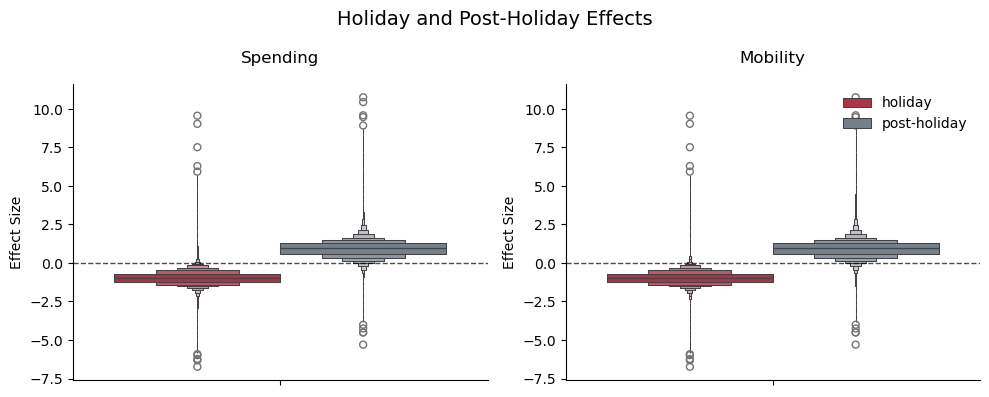

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Define holiday-themed color palette
# Red for holiday (festive, celebration) and gray for post-holiday (return to normal)
holiday_colors = ['#C41E3A', '#708090']  # Deep red and slate gray

# Alternative color options you can try:
# holiday_colors = ['#228B22', '#8B4513']  # Forest green and saddle brown
# holiday_colors = ['#DAA520', '#4682B4']  # Goldenrod and steel blue
# holiday_colors = ['#8B0000', '#2F4F4F']  # Dark red and dark slate gray

# Create boxenplots with custom colors
sns.boxenplot(y='Value', data=df_spend_boxen, hue="Effect", ax=ax[0], palette=holiday_colors)
sns.boxenplot(y='Value', data=df_mobility_boxen, hue="Effect", ax=ax[1], palette=holiday_colors)

# Add horizontal dashed line at y=0 for both subplots
ax[0].axhline(y=0, color='black', linestyle='--', alpha=0.7, linewidth=1)
ax[1].axhline(y=0, color='black', linestyle='--', alpha=0.7, linewidth=1)

# Remove top and right spines for both subplots
for axis in [ax[0], ax[1]]:
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)

# Improve labels and titles
ax[0].set_ylabel("Effect Size")
ax[1].set_ylabel("Effect Size")
ax[0].set_title("Spending", pad=15)
ax[1].set_title("Mobility", pad=15)

# Improve legend - remove from ax[0] if it exists, keep only on ax[1]
if ax[0].get_legend():
    ax[0].get_legend().remove()
ax[1].legend(loc="upper right", frameon=False)

# Add overall figure title
fig.suptitle('Holiday and Post-Holiday Effects', fontsize=14)
plt.tight_layout()
fig.savefig(os.path.join(fig_path, "holiday_effects.png"), dpi=300)

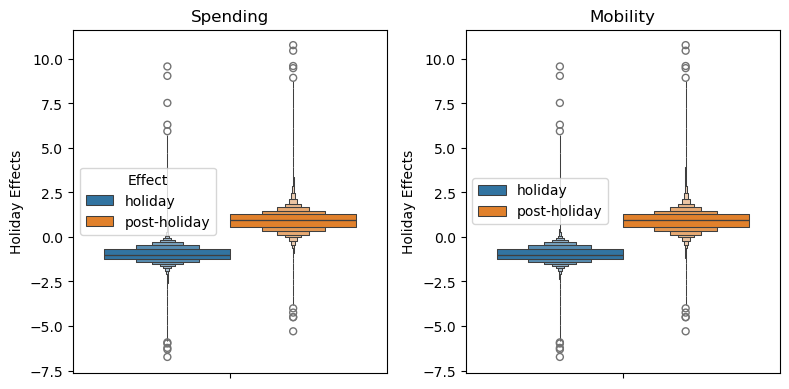

In [35]:
fig, ax = plt.subplots(1,2, figsize=(8, 4))
sns.boxenplot(y='Value', data=df_spend_boxen, hue="Effect", ax=ax[0])
# fig.suptitle('Holiday and rebound effects relative to mean daily spend')
ax[0].set_ylabel("Holiday Effects")
# ax.hlines(y=0, xmin="holiday", xmax="holiday+1")
sns.boxenplot(y='Value', data=df_mobility_boxen, hue="Effect", ax=ax[1])
# fig.suptitle('Holiday and rebound effects relative to mean daily spend')
ax[1].set_ylabel("Holiday Effects")
ax[0].set_title("Spending")
ax[1].set_title("Mobility")
ax[1].legend(loc="best")
plt.tight_layout()

# Choropleth for predicting ECE-mobility

Choropleth for the ECE mobility acros states
a) For ECE features
b) For sociodemographics
c) Combined

In [37]:
census_data_path = "/home/rat884/code/heat_cold_asymmetry/data/combined_census_tract_data.csv"
df_census = pd.read_csv(census_data_path, dtype={"GEOID":str})
df_census.set_index("GEOID", inplace=True)
del df_census["year"]

In [38]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [39]:
census_endo = df_census.select_dtypes(include=np.number).columns.tolist()
census_endo_d = [_ for _ in census_endo if _.split("_")[0]=="d"]

In [40]:
ee_mobility_ece = ee_params_mobility_all[ee_params_mobility_all["event_type"]=="Extreme Cold Event"]
ee_mobility_ehe = ee_params_mobility_all[ee_params_mobility_all["event_type"]=="Extreme Heat Event"]

In [41]:
ee_numeric_cols = ee_mobility_ece.select_dtypes(include=np.number).columns.tolist()
drop_cols = ['mean',
 'std',
 'ee_ratio',
 'holiday_effect',
 'year',
 'ee_ratio_std',
 'GEOID', 'resid', "total_area", "impacted_to_total_ratio",	"impacted_area_hectare"]
ee_endo = [n for n in ee_numeric_cols if n not in drop_cols]

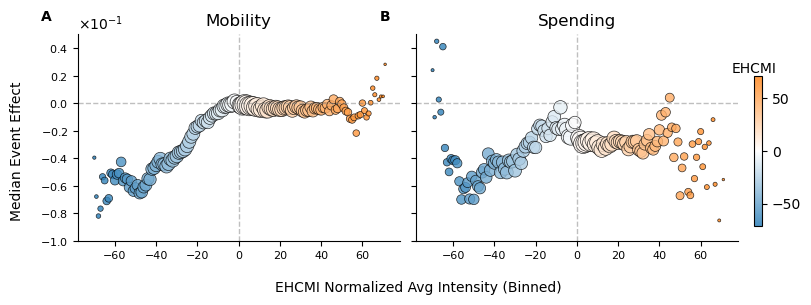

In [42]:
# Method 1: Adjust the y position of supxlabel (Current method - modify this)
# Change this:

fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
# fig.supxlabel('EHCMI Normalized Avg Intensity (Binned)', y=0)

# To this (negative values move the label down, creating more space):
# fig.supxlabel('EHCMI Normalized Avg Intensity (Binned)', y=-0.02)
# Or for more space:
# fig.supxlabel('EHCMI Normalized Avg Intensity (Binned)', y=-0.05)

# Method 2: Use subplots_adjust to create more space at the bottom
plt.subplots_adjust(bottom=0.15, right=0.9)  # Increase bottom margin
# fig.supxlabel('EHCMI Normalized Avg Intensity (Binned)')  # Remove y=0

# Method 3: Adjust individual axis label padding
for axis in [ax[0], ax[1]]:
    axis.xaxis.labelpad = 10  # Add padding to individual x-axis labels
    axis.yaxis.labelpad = 10  # Add padding to individual y-axis labels

# Method 4: Manual positioning with text
# Remove supxlabel and add custom text
fig.text(0.5, 0.02, 'EHCMI Normalized Avg Intensity (Binned)', 
         ha='center', va='bottom', fontsize=plt.rcParams['font.size'])

# Method 5: Use tight_layout with padding
plt.tight_layout(pad=2.0)  # Add overall padding
# fig.supxlabel('EHCMI Normalized Avg Intensity (Binned)', y=0.02)

# COMPLETE SOLUTION for your code:
def create_blue_white_orange_cmap():
    """Create custom colormap with blue for negative, white for zero, orange for positive"""
    colors = ['#1f77b4', 'white', '#ff7f0e']  # Blue -> White -> Orange
    custom_cmap = LinearSegmentedColormap.from_list('blue_white_orange', colors, N=256)
    return custom_cmap

# Create the colormap
custom_cmap = create_blue_white_orange_cmap()

def get_binned_data(df, bin_size=1, min_count_threshold=10):
    # Create bins for EHCMI values
    df_copy = df.copy()
    
    # Create bin labels by flooring the EHCMI values to nearest bin_size
    df_copy['ehcmi_bin'] = (df_copy['EHCMI_normalized_avg_intensity'] / bin_size).astype(int) * bin_size
    
    # Group by bins and calculate median ee_ratio for each bin
    binned_data = df_copy.groupby('ehcmi_bin').agg({
        'ee_ratio': ['median', 'count', 'std', 'mean']
    }).round(6)
    
    # Flatten column names
    binned_data.columns = ['median_ee_ratio', 'count', 'std_ee_ratio', 'mean_ee_ratio']
    binned_data = binned_data.reset_index()
    
    # Remove bins with very few data points (optional - you can adjust this threshold)
    binned_data = binned_data[binned_data['count'] >= min_count_threshold]
    return binned_data

# Create figure with adjusted spacing for colorbar

# SOLUTION: Adjust layout to create space for labels
plt.subplots_adjust(bottom=0.2, right=0.9)  # Increased bottom margin for x-label space

bin_size = 1
binned_mobility = get_binned_data(ee_params_mobility_all, bin_size=bin_size)
binned_spend = get_binned_data(ee_params_spend_all, bin_size=bin_size)

# Find common vmin and vmax for consistent coloring across both plots
all_ehcmi_values = np.concatenate([binned_mobility['ehcmi_bin'], binned_spend['ehcmi_bin']])
vmin_common = all_ehcmi_values.min()
vmax_common = all_ehcmi_values.max()

# First subplot (Mobility)
binned_data = binned_mobility
sizes = np.sqrt(binned_data['count'])
scatter1 = ax[0].scatter(binned_data['ehcmi_bin'], binned_data['median_ee_ratio'], 
                        s=sizes, alpha=0.8, c=binned_data['ehcmi_bin'], 
                        cmap=custom_cmap, edgecolors='black', linewidth=0.5,
                        vmin=vmin_common, vmax=vmax_common)

# Second subplot (Spending)
binned_data = binned_spend
sizes = np.sqrt(binned_data['count'])
scatter2 = ax[1].scatter(binned_data['ehcmi_bin'], binned_data['median_ee_ratio'], 
                        s=sizes, alpha=0.8, c=binned_data['ehcmi_bin'], 
                        cmap=custom_cmap, edgecolors='black', linewidth=0.5,
                        vmin=vmin_common, vmax=vmax_common)

# Create a single colorbar for both subplots
cbar_ax = fig.add_axes([0.92, 0.25, 0.01, 0.5])  # [left, bottom, width, height]
cbar = fig.colorbar(scatter1, cax=cbar_ax, orientation='vertical')
cbar.ax.yaxis.set_label_position('left') 
cbar.set_label('EHCMI', rotation=0, labelpad=0, y=1.0, x=0.0)

# SOLUTION: Set labels with proper spacing
# fig.supxlabel('EHCMI Normalized Avg Intensity (Binned)', y=0.05, fontsize=10)  # Removed y=0
fig.supylabel('Median Event Effect', x=-0.01, fontsize=10)

ax[0].set_title("Mobility")
ax[0].set_ylim([-0.085, 0.03])
ax[1].set_title("Spending")
ax[1].set_ylim([-0.1, 0.05])

# Remove top and right spines and format axes
for axis in [ax[0], ax[1]]:
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    
    # Optional: make left and bottom spines thinner
    axis.spines['left'].set_linewidth(0.8)
    axis.spines['bottom'].set_linewidth(0.8)
    axis.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
    axis.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    axis.axvline(x=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    
    # SOLUTION: Add padding to individual axis labels if needed
    axis.xaxis.labelpad = 2  # Add space between x-axis and its tick labels
    axis.yaxis.labelpad = 2  # Add space between y-axis and its tick labels
    axis.tick_params(axis='both', which='major', labelsize=8)

# plt.tight_layout()
panel_labels = ['A', 'B']
panels = [ax[0], ax[1]]  # Clockwise: top-left, top-right, bottom-right, bottom-left

for label, panel in zip(panel_labels, panels):
    panel.text(-0.08, 1.05, label, transform=panel.transAxes, 
              fontsize=10, fontweight='bold', va='bottom', ha='right')

plt.subplots_adjust(wspace=0.05) 
fig.savefig(os.path.join(fig_path, "ee_ehcmi.png"), dpi=300, bbox_inches='tight')

# Alternative approaches for fine-tuning:

# Option A: More space with negative y position
# fig.supxlabel('EHCMI Normalized Avg Intensity (Binned)', y=-0.08)

# Option B: Custom text positioning
# fig.text(0.5, 0.02, 'EHCMI Normalized Avg Intensity (Binned)', 
#          ha='center', va='bottom', fontsize=10)

# Option C: Use tight_layout with rect parameter to reserve space
# plt.tight_layout(rect=[0, 0.05, 1, 1])  # [left, bottom, right, top]
# fig.supxlabel('EHCMI Normalized Avg Intensity (Binned)', y=0.02)

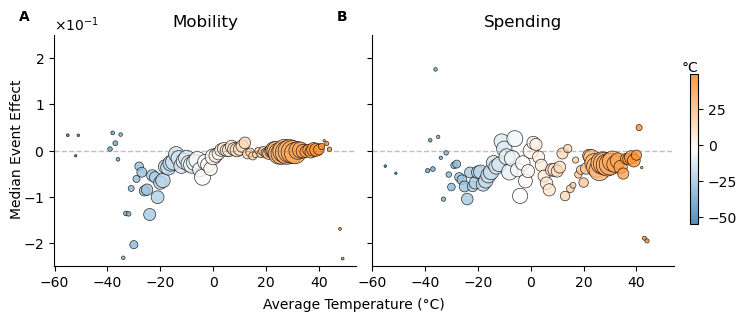

In [43]:
var_int = 'd_temperature_avg_avg_intensity'
y_scatter = 'median_ee_ratio'
def create_blue_white_orange_cmap():
    """Create custom colormap with blue for negative, white for zero, orange for positive"""
    colors = ['#1f77b4', 'white', '#ff7f0e']  # Blue -> White -> Orange
    custom_cmap = LinearSegmentedColormap.from_list('blue_white_orange', colors, N=256)
    return custom_cmap

# Create the colormap
custom_cmap = create_blue_white_orange_cmap()

def get_binned_data(df, bin_size=1, min_count_threshold=10):
    # Create bins for EHCMI values
    df_copy = df.copy()
    
    # Create bin labels by flooring the EHCMI values to nearest bin_size
    df_copy['ehcmi_bin'] = (df_copy[var_int] / bin_size).astype(int) * bin_size
    
    # Group by bins and calculate median ee_ratio for each bin
    binned_data = df_copy.groupby('ehcmi_bin').agg({
        'ee_ratio': ['median', 'count', 'std', 'mean']
    }).round(6)
    
    # Flatten column names
    binned_data.columns = ['median_ee_ratio', 'count', 'std_ee_ratio', 'mean_ee_ratio']
    binned_data = binned_data.reset_index()
    
    # Remove bins with very few data points (optional - you can adjust this threshold)
    binned_data = binned_data[binned_data['count'] >= min_count_threshold]
    return binned_data

# Create figure with adjusted spacing for colorbar
fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
# Method 3: Adjust individual axis label padding
for axis in [ax[0], ax[1]]:
    axis.xaxis.labelpad = 10  # Add padding to individual x-axis labels
    axis.yaxis.labelpad = 10  # Add padding to individual y-axis labels

# Method 4: Manual positioning with text
# Remove supxlabel and add custom text
fig.text(0.5, -.04, 'Average Temperature (°C)', 
         ha='center', va='bottom', fontsize=plt.rcParams['font.size'])
fig.supylabel('Median Event Effect', x=0.07, fontsize=10)

bin_size = 1
binned_mobility = get_binned_data(ee_params_mobility_all, bin_size=bin_size)
binned_spend = get_binned_data(ee_params_spend_all, bin_size=bin_size)

# Find common vmin and vmax for consistent coloring across both plots
all_ehcmi_values = np.concatenate([binned_mobility['ehcmi_bin'], binned_spend['ehcmi_bin']])
vmin_common = all_ehcmi_values.min()
vmax_common = all_ehcmi_values.max()

# First subplot (Mobility)
binned_data = binned_mobility
sizes = np.sqrt(binned_data['count'])
scatter1 = ax[0].scatter(binned_data['ehcmi_bin'], binned_data[y_scatter], 
                        s=sizes, alpha=0.8, c=binned_data['ehcmi_bin'], 
                        cmap=custom_cmap, edgecolors='black', linewidth=0.5,
                        vmin=vmin_common, vmax=vmax_common)

# Second subplot (Spending)
binned_data = binned_spend
sizes = np.sqrt(binned_data['count'])
scatter2 = ax[1].scatter(binned_data['ehcmi_bin'], binned_data[y_scatter], 
                        s=sizes, alpha=0.8, c=binned_data['ehcmi_bin'], 
                        cmap=custom_cmap, edgecolors='black', linewidth=0.5,
                        vmin=vmin_common, vmax=vmax_common)

# FIXED: Position colorbar INSIDE figure boundaries
cbar_ax = fig.add_axes([0.92, 0.25, 0.01, 0.5])  # [left, bottom, width, height]
cbar = fig.colorbar(scatter1, cax=cbar_ax, orientation='vertical')
cbar.ax.yaxis.set_label_position('left') 
cbar.set_label('°C', rotation=0, labelpad=0, y=1.0, x=0.0)

# Set labels and titles
# fig.supxlabel('{} (Binned)'.format(var_int))
# fig.supylabel(y_scatter, x=-0.02)

ax[0].set_title("Mobility")
ax[0].set_ylim([-0.25, 0.25])
ax[1].set_title("Spending")
# ax[1].set_ylim([-0.1, 0.05])

# Remove top and right spines and format axes
for axis in [ax[0], ax[1]]:
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    
    # Optional: make left and bottom spines thinner
    axis.spines['left'].set_linewidth(0.8)
    axis.spines['bottom'].set_linewidth(0.8)
    axis.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
    axis.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)

# plt.tight_layout()
panel_labels = ['A', 'B']
panels = [ax[0], ax[1]]  # Clockwise: top-left, top-right, bottom-right, bottom-left

for label, panel in zip(panel_labels, panels):
    panel.text(-0.08, 1.05, label, transform=panel.transAxes, 
              fontsize=10, fontweight='bold', va='bottom', ha='right')

plt.subplots_adjust(wspace=0.05)
fig.savefig(os.path.join(fig_path, "dose_response_temp.png"), dpi=300, bbox_inches='tight')


In [44]:
# Check if the dose response relationship between EHCMI and EE effect persists even when heat and cold are matched for temperature ranges
var_int = 'd_temperature_avg_avg_intensity'
z_sc = 2
ee_params_mobility_all_cold = ee_params_mobility_all[ee_params_mobility_all['event_type']=="Extreme Cold Event"]
ee_params_mobility_all_heat = ee_params_mobility_all[ee_params_mobility_all['event_type']=="Extreme Heat Event"]
mobility_cold_mean_temp = ee_params_mobility_all_cold[var_int].mean()
mobility_heat_mean_temp = ee_params_mobility_all_heat[var_int].mean()

t_std = ee_params_mobility_all_heat[var_int].std()

ee_params_mobility_all_cold_truncate = ee_params_mobility_all_cold[ee_params_mobility_all_cold[var_int].between(mobility_cold_mean_temp-z_sc*t_std, mobility_cold_mean_temp+z_sc*t_std)]
ee_params_mobility_all_heat_truncate = ee_params_mobility_all_heat[ee_params_mobility_all_heat[var_int].between(mobility_heat_mean_temp-z_sc*t_std, mobility_heat_mean_temp+z_sc*t_std)]
ee_params_mobility_all_truncate = pd.concat([ee_params_mobility_all_cold_truncate, ee_params_mobility_all_heat_truncate], axis=0)


In [45]:

ee_params_spend_all_cold = ee_params_spend_all[ee_params_spend_all['event_type']=="Extreme Cold Event"]
ee_params_spend_all_heat = ee_params_spend_all[ee_params_spend_all['event_type']=="Extreme Heat Event"]
spend_cold_mean_temp = ee_params_spend_all_cold[var_int].mean()
spend_heat_mean_temp = ee_params_spend_all_heat[var_int].mean()

t_std = ee_params_spend_all_heat[var_int].std()

ee_params_spend_all_cold_truncate = ee_params_spend_all_cold[ee_params_spend_all_cold[var_int].between(spend_cold_mean_temp-z_sc*t_std, spend_cold_mean_temp+z_sc*t_std)]
ee_params_spend_all_heat_truncate = ee_params_spend_all_heat[ee_params_spend_all_heat[var_int].between(spend_heat_mean_temp-z_sc*t_std, spend_heat_mean_temp+z_sc*t_std)]
# ee_params_spend_all_cold_truncate = ee_params_spend_all_cold[ee_params_spend_all_cold[var_int].between(mobility_cold_mean_temp-z_sc*t_std, mobility_cold_mean_temp+z_sc*t_std)]
# ee_params_spend_all_heat_truncate = ee_params_spend_all_heat[ee_params_spend_all_heat[var_int].between(mobility_heat_mean_temp-z_sc*t_std, mobility_heat_mean_temp+z_sc*t_std)]
ee_params_spend_all_truncate = pd.concat([ee_params_spend_all_cold_truncate, ee_params_spend_all_heat_truncate], axis=0)

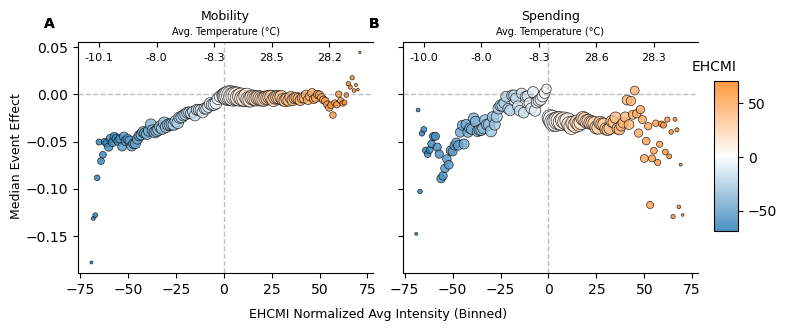

In [46]:
# First, modify get_binned_data to include the temperature column
y_scatter = 'median_ee_ratio'
def create_blue_white_orange_cmap():
    """Create custom colormap with blue for negative, white for zero, orange for positive"""
    colors = ['#1f77b4', 'white', '#ff7f0e']  # Blue -> White -> Orange
    custom_cmap = LinearSegmentedColormap.from_list('blue_white_orange', colors, N=256)
    return custom_cmap

# Create the colormap
custom_cmap = create_blue_white_orange_cmap()

def get_binned_data(df, bin_size=1, min_count_threshold=10):
    # Create bins for EHCMI values
    df_copy = df.copy()
    
    # Create bin labels by flooring the EHCMI values to nearest bin_size
    df_copy['ehcmi_bin'] = (df_copy['EHCMI_normalized_avg_intensity'] / bin_size).astype(int) * bin_size
    
    # Group by bins and calculate statistics for each bin
    binned_data = df_copy.groupby('ehcmi_bin').agg({
        'ee_ratio': ['median', 'count', 'std', 'mean'],
        'd_temperature_avg_avg_intensity': 'mean'  # Add temperature column
    }).round(6)
    
    # Flatten column names
    binned_data.columns = ['median_ee_ratio', 'count', 'std_ee_ratio', 'mean_ee_ratio', 'd_temperature_avg']
    binned_data = binned_data.reset_index()
    
    # Remove bins with very few data points
    binned_data = binned_data[binned_data['count'] >= min_count_threshold]
    return binned_data

# Create figure with adjusted spacing for colorbar
var_int = 'EHCMI_normalized_avg_intensity'
fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)

# Position subplots
ax[0].set_position([0.1, 0.55, 0.7, 0.35])
ax[1].set_position([0.1, 0.1, 0.7, 0.35])

bin_size = 1
binned_mobility = get_binned_data(ee_params_mobility_all_truncate, bin_size=bin_size)
binned_spend = get_binned_data(ee_params_spend_all_truncate, bin_size=bin_size)

# Find common vmin and vmax for consistent coloring across both plots
all_ehcmi_values = np.concatenate([binned_mobility['ehcmi_bin'], binned_spend['ehcmi_bin']])
vmin_common = all_ehcmi_values.min()
vmax_common = all_ehcmi_values.max()

# First subplot (Mobility)
binned_data = binned_mobility
sizes = np.sqrt(binned_data['count'])
scatter1 = ax[0].scatter(binned_data['ehcmi_bin'], binned_data[y_scatter], 
                         s=sizes, alpha=0.8, c=binned_data['ehcmi_bin'], 
                         cmap=custom_cmap, edgecolors='black', linewidth=0.5,
                         vmin=vmin_common, vmax=vmax_common)

# Create secondary x-axis for top subplot (Mobility)
top_ticks = list(range(-65, 66, 30))
bm_temp = binned_mobility.groupby('ehcmi_bin')['d_temperature_avg'].mean()
bm_avg_temp = bm_temp[top_ticks].values
ax0_top = ax[0].twiny()
ax0_top.set_xlim(ax[0].get_xlim())
# Map temperature values to EHCMI positions
temp_ticks = ax[0].get_xticks()
temp_labels = np.interp(temp_ticks, 
                         binned_mobility['ehcmi_bin'], 
                         binned_mobility['d_temperature_avg'])
# ax0_top.set_xticks(temp_ticks[1:-1])
# ax0_top.set_xticklabels([f'{val:.1f}' for val in temp_labels[1:-1]], fontsize=8)
ax0_top.set_xticks(top_ticks)
ax0_top.set_xticklabels([f'{val:.1f}' for val in bm_avg_temp], fontsize=8)

ax0_top.set_xlabel('Avg. Temperature (°C)', fontsize=7, labelpad=5)
ax0_top.spines['top'].set_linewidth(0.8)
ax0_top.spines['bottom'].set_visible(False)
ax0_top.spines['left'].set_visible(False)
ax0_top.spines['right'].set_visible(False)
ax0_top.tick_params(axis='x', which='major', labelsize=8, direction='in', pad=-15)

# Second subplot (Spending)
binned_data = binned_spend
sizes = np.sqrt(binned_data['count'])
scatter2 = ax[1].scatter(binned_data['ehcmi_bin'], binned_data[y_scatter], 
                         s=sizes, alpha=0.8, c=binned_data['ehcmi_bin'], 
                         cmap=custom_cmap, edgecolors='black', linewidth=0.5,
                         vmin=vmin_common, vmax=vmax_common)

# Create secondary x-axis for bottom subplot (Spending)
ax1_top = ax[1].twiny()
bs_temp = binned_spend.groupby('ehcmi_bin')['d_temperature_avg'].mean()
bs_avg_temp = bs_temp[top_ticks].values
ax1_top.set_xlim(ax[1].get_xlim())
temp_labels_spend = np.interp(temp_ticks, 
                               binned_spend['ehcmi_bin'], 
                               binned_spend['d_temperature_avg'])
ax1_top.set_xticks(top_ticks)
ax1_top.set_xticklabels([f'{val:.1f}' for val in bs_avg_temp], fontsize=8)
ax1_top.set_xlabel('Avg. Temperature (°C)', fontsize=7, labelpad=5)
ax1_top.spines['top'].set_linewidth(0.8)
ax1_top.spines['bottom'].set_visible(False)
ax1_top.spines['left'].set_visible(False)
ax1_top.spines['right'].set_visible(False)
ax1_top.tick_params(axis='x', which='major', labelsize=8, direction='in', pad=-15)

# Position colorbar INSIDE figure boundaries
cbar_ax = fig.add_axes([0.92, 0.25, 0.03, 0.5])
cbar = fig.colorbar(scatter1, cax=cbar_ax, orientation='vertical')
cbar.ax.yaxis.set_label_position('left') 
cbar.set_label('EHCMI', rotation=0, labelpad=0, y=1.05, x=0)

# Set labels and titles
fig.supxlabel('EHCMI Normalized Avg Intensity (Binned)', y=-0.05, fontsize=9)
fig.supylabel('Median Event Effect', x=0.04, fontsize=9)
ax[0].set_title("Mobility", y = 1.06, fontsize=9)
ax[1].set_title("Spending", y = 1.06, fontsize=9)

# Remove top and right spines and format axes (for primary axes)
for axis in [ax[0], ax[1]]:
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    axis.spines['left'].set_linewidth(0.8)
    axis.spines['bottom'].set_linewidth(0.8)
    # axis.ticklabel_format(style='scientific', axis='y', scilimits=(0,0), useMathText=True)
    axis.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    axis.axvline(x=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)

# plt.tight_layout()
panel_labels = ['A', 'B']
panels = [ax[0], ax[1]]  # Clockwise: top-left, top-right, bottom-right, bottom-left

for label, panel in zip(panel_labels, panels):
    panel.text(-0.08, 1.05, label, transform=panel.transAxes, 
              fontsize=10, fontweight='bold', va='bottom', ha='right')

for label, panel in zip(panel_labels, panels):
    panel.text(-0.08, 1.05, label, transform=panel.transAxes, 
              fontsize=10, fontweight='bold', va='bottom', ha='right')

plt.subplots_adjust(wspace=0.1) 
# plt.tight_layout()
fig.savefig(os.path.join(fig_path, 'ehcmi_dose_response_matched_t_range.png'), dpi=300, bbox_inches='tight')

# Ability of extreme event and socio-demographic characteristics to explain the variance in the extreme cold event effects

In [48]:
# Effect Sizes in the regression model
import random
behaviour = "mobility"
ee_mobility_ece_demo = pd.merge(ee_mobility_ece, df_census, left_on="census_tract", right_index=True, how="inner")
ts_var = 'ee_ratio'
features = ee_endo + census_endo_d + [ts_var] + ['census_tract']
X = ee_mobility_ece_demo[features]
X.dropna(inplace=True)
X_model = X[ee_endo + census_endo_d + ['census_tract']]
ct_unique = X_model['census_tract'].unique().tolist()
print(len(ct_unique))
random.seed(42)
random.shuffle(ct_unique)
ct_n_train = int(len(ct_unique)*0.8)
ct_train = ct_unique[:ct_n_train]
ct_test = ct_unique[ct_n_train:]
y_model = X[ts_var]
X_train = X[X['census_tract'].isin(ct_train)][ee_endo + census_endo_d]
y_train = X[X['census_tract'].isin(ct_train)][ts_var]
X_test = X[X['census_tract'].isin(ct_test)][ee_endo + census_endo_d]
y_test = X[X['census_tract'].isin(ct_test)][ts_var]


alphas = np.logspace(-2, 4, 16)

ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X_train, y_train)
train_score = ridge_cv.score(X_train, y_train)
score = ridge_cv.score(X_test, y_test)
print("Train Score", train_score)
print("Test Score", score)

print(f"Best alpha: {ridge_cv.alpha_}")
print(f"CV score: {ridge_cv.best_score_}")


/tmp/ipykernel_2643288/1324192826.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



46844


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.66141e-25): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.68058e-25): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.45772e-25): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.8547e-25): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.93074e-25): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-package

Train Score 0.09034114830773754
Test Score 0.08243114917085037
Best alpha: 630.9573444801943
CV score: -0.022668871276198505


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.7695e-20): result may not be accurate.



In [14]:
import statsmodels.api as sm
X_train_with_const = sm.add_constant(X_train)

# Fit the OLS (Ordinary Least Squares) model
model = sm.OLS(y_train, X_train_with_const).fit()

# Get the summary with coefficients and p-values
print(model.summary())

# Extract coefficients and p-values separately
coefficients = model.params
p_values = model.pvalues

print("\nCoefficients:")
print(coefficients)
print("\nP-values:")
print(p_values)
coef_df = pd.DataFrame({
    'Coefficient': coefficients,
    'P-value': p_values
})
print("\nCoefficients and P-values:")
print(coef_df)
# coef_df.to_csv("/home/rat884/code/ipy_notebooks/footfall_cbg_analysis/data/coef_mobility.csv")

                            OLS Regression Results                            
Dep. Variable:               ee_ratio   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     383.7
Date:                Fri, 14 Nov 2025   Prob (F-statistic):               0.00
Time:                        21:40:29   Log-Likelihood:             1.5938e+05
No. Observations:              345573   AIC:                        -3.186e+05
Df Residuals:                  345486   BIC:                        -3.177e+05
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

In [51]:
states_list = pd.unique(ee_mobility_ece["STUSPS"]).tolist()

# Generate sample data

# end_features = corr_subset.index.tolist()
# end_features_d = [x for x in end_features if x.split("_")[0] == "d"]
ts_var = 'ee_ratio'
end_features = census_endo_d + ee_endo
features = end_features + [ts_var, 'census_tract']
st_dict = {}
coef_dict = {}
alpha_dict = {}
for st in states_list:
    print("State", st)
    state_df = ee_mobility_ece_demo[ee_mobility_ece_demo["STUSPS"].isin([st])]
    X = state_df[features]
    X.dropna(inplace=True)
    ct_unique = X['census_tract'].unique().tolist()
    random.seed(42)
    random.shuffle(ct_unique)
    ct_n_train = int(len(ct_unique)*0.8)
    ct_train = ct_unique[:ct_n_train]
    ct_test = ct_unique[ct_n_train:]
    X_train = X[X['census_tract'].isin(ct_train)][ee_endo + census_endo_d]
    y_train = X[X['census_tract'].isin(ct_train)][ts_var]
    X_test = X[X['census_tract'].isin(ct_test)][ee_endo + census_endo_d]
    y_test = X[X['census_tract'].isin(ct_test)][ts_var]

    X_model = X[end_features]
    y_model = X[ts_var]
    # X_train, X_test, y_train, y_test = train_test_split(X_model, y_model, test_size=0.2, random_state=42)

    # Create LassoCV model
    # alphas: range of regularization strengths to try
    # cv: number of cross-validation folds (default is 5)
    # lasso_cv = LassoCV(
    #     cv=4,
    #     alphas=np.logspace(0, 4, 8),
    #     max_iter=8000,
    #     random_state=42, n_jobs=-1
    # )

    # # Fit the model
    # lasso_cv.fit(X_train, y_train)

    ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
    ridge_cv.fit(X_train, y_train)
    train_score = ridge_cv.score(X_train, y_train)
    score = ridge_cv.score(X_test, y_test)

    # reg = LinearRegression().fit(X_train, y_train)
    # train_score = reg.score(X_train, y_train)
    # score = reg.score(X_test, y_test)
    st_dict[st] = score
    # alpha_dict[st] = lasso_cv.alpha_
    # coef_dict[st] = reg.coef_
    print(f"R² score on train data (state {st}): {train_score:.4f}")
    print(f"R² score on test data (state {st}): {score:.4f}")


State AZ


/tmp/ipykernel_2643288/539256843.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.67252e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=9.65029e-24): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=5.69337e-24): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.01625e-23): resu

R² score on train data (state AZ): 0.0094
R² score on test data (state AZ): -0.0131
State AR


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.31713e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.23975e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.55308e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=6.02473e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=8.01177e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packag

R² score on train data (state AR): 0.2393
R² score on test data (state AR): 0.1233
State CA


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.87219e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.2429e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.50592e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.33685e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=3.47121e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-package

R² score on train data (state CA): 0.0060
R² score on test data (state CA): 0.0042
State CO


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.27585e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.93784e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.18302e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.17103e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.24547e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packag

R² score on train data (state CO): 0.1211
R² score on test data (state CO): 0.1307
State DE


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.20514e-18): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.01203e-18): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=9.28129e-19): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.70793e-18): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.46049e-18): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packag

R² score on train data (state DE): 0.0409
R² score on test data (state DE): 0.0019
State DC


/tmp/ipykernel_2643288/539256843.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.33843e-17): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.83511e-17): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.3737e-17): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.16033e-17): resul

R² score on train data (state DC): 0.0445
R² score on test data (state DC): -0.2510
State GA


/tmp/ipykernel_2643288/539256843.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.75716e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=7.68477e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.86074e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.5376e-22): resul

R² score on train data (state GA): 0.0440
R² score on test data (state GA): 0.0035
State ID


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.30722e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.20862e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=3.50724e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.77903e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=3.55934e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packag

R² score on train data (state ID): 0.0492
R² score on test data (state ID): -0.0657
State IL


/tmp/ipykernel_2643288/539256843.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.95146e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=3.66078e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=3.36378e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=3.3368e-23): resul

R² score on train data (state IL): 0.3422
R² score on test data (state IL): 0.3601
State IN


/tmp/ipykernel_2643288/539256843.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.73798e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.71365e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.80536e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.76684e-22): resu

R² score on train data (state IN): 0.1932
R² score on test data (state IN): 0.2146
State IA


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=7.14315e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=6.74309e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=6.69665e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.66396e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.57839e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packag

R² score on train data (state IA): 0.1750
R² score on test data (state IA): 0.1587
State KS


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=4.3072e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.10117e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.26569e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.05154e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.38261e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-package

R² score on train data (state KS): 0.1517
R² score on test data (state KS): 0.1565
State KY


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=6.46538e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.40358e-21): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.62665e-21): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.48127e-21): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.39245e-21): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packag

R² score on train data (state KY): 0.0813
R² score on test data (state KY): 0.0527
State LA


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=4.2169e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=4.1106e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=4.21789e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=4.19491e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=4.48378e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages

R² score on train data (state LA): 0.2586
R² score on test data (state LA): 0.2472
State ME


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=8.35176e-19): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=6.36547e-19): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=6.01827e-19): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=6.089e-19): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.05842e-18): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages

R² score on train data (state ME): 0.0539
R² score on test data (state ME): 0.0217
State MD


/tmp/ipykernel_2643288/539256843.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.22912e-21): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.03873e-21): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.04988e-21): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=6.31072e-22): resu

R² score on train data (state MD): 0.0172
R² score on test data (state MD): -0.0011
State MA


/tmp/ipykernel_2643288/539256843.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.85477e-21): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.99381e-21): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.27896e-21): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.43412e-21): resu

R² score on train data (state MA): 0.1032
R² score on test data (state MA): 0.1029
State MI


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=9.76973e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=9.10131e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=9.01675e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.00742e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=7.49007e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packag

R² score on train data (state MI): 0.1344
R² score on test data (state MI): 0.1275
State MN


/tmp/ipykernel_2643288/539256843.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=9.48055e-24): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=9.62119e-24): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=9.29487e-24): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=8.81355e-24): resu

R² score on train data (state MN): 0.1996
R² score on test data (state MN): 0.2017
State MS


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=9.74977e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.27637e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.70055e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.25954e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.31332e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packag

R² score on train data (state MS): 0.1550
R² score on test data (state MS): 0.1417
State MO


/tmp/ipykernel_2643288/539256843.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=3.39141e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=3.21814e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=3.49957e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=3.31072e-23): resu

R² score on train data (state MO): 0.1543
R² score on test data (state MO): 0.1679
State MT


/tmp/ipykernel_2643288/539256843.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.62425e-24): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.83747e-24): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.66053e-24): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.62134e-24): resu

R² score on train data (state MT): 0.0490
R² score on test data (state MT): 0.0051
State NE


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.40393e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.36157e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.48419e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.4284e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.8359e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages

R² score on train data (state NE): 0.1692
R² score on test data (state NE): 0.1501
State NV


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=5.17395e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=5.23248e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=4.17814e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=9.44871e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.39779e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packag

R² score on train data (state NV): 0.0148
R² score on test data (state NV): -0.0108
State NH


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=9.32419e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=7.03589e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=9.28671e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=9.50796e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=7.30163e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packag

R² score on train data (state NH): 0.0794
R² score on test data (state NH): -0.0588
State NJ


/tmp/ipykernel_2643288/539256843.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.8182e-21): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.86155e-21): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.15112e-21): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.34277e-21): resul

R² score on train data (state NJ): 0.0471
R² score on test data (state NJ): 0.0345
State NM


/tmp/ipykernel_2643288/539256843.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=7.6011e-24): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.364e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.05265e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=8.71048e-24): result 

R² score on train data (state NM): 0.0521
R² score on test data (state NM): 0.0280
State NY


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.03155e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=7.71325e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.00033e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=8.2994e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=9.03436e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-package

R² score on train data (state NY): 0.1119
R² score on test data (state NY): 0.1015
State NC


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=7.17022e-20): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=7.44084e-20): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=3.50043e-19): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.69314e-19): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.02781e-19): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packag

R² score on train data (state NC): 0.0678
R² score on test data (state NC): 0.0317
State ND


/tmp/ipykernel_2643288/539256843.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=4.63483e-24): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=5.01355e-24): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=4.9421e-24): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=4.8191e-24): result

R² score on train data (state ND): 0.0635
R² score on test data (state ND): 0.0693
State OH


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.59483e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.71902e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.7893e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.67334e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.74003e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-package

R² score on train data (state OH): 0.0658
R² score on test data (state OH): 0.0775
State OK


/tmp/ipykernel_2643288/539256843.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.69297e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=3.49797e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=3.00158e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=3.03448e-23): resu

R² score on train data (state OK): 0.1749
R² score on test data (state OK): 0.1443
State OR


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=7.50742e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=5.86974e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=9.10625e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.08156e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=7.16467e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packag

R² score on train data (state OR): 0.3059
R² score on test data (state OR): 0.1279
State PA


/tmp/ipykernel_2643288/539256843.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.1089e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.08966e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.08936e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.20133e-22): resul

R² score on train data (state PA): 0.0276
R² score on test data (state PA): 0.0254
State RI


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.9734e-18): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.73687e-18): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.51666e-18): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.99838e-18): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=3.66337e-18): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-package

R² score on train data (state RI): 0.2591
R² score on test data (state RI): 0.2015
State SC


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=6.37433e-21): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=7.176e-21): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.65034e-20): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.55351e-20): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.84616e-20): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages

R² score on train data (state SC): 0.0670
R² score on test data (state SC): 0.0333
State SD


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.61253e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.76147e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=4.13229e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=4.38655e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=4.37363e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packag

R² score on train data (state SD): 0.1462
R² score on test data (state SD): 0.0834
State TN


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.90016e-21): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=3.39077e-21): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=5.59274e-21): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=7.33505e-21): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=5.58185e-21): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packag

R² score on train data (state TN): 0.2050
R² score on test data (state TN): 0.1412
State TX


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=5.76926e-24): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=7.19075e-24): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.56489e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.43652e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.77657e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packag

R² score on train data (state TX): 0.1814
R² score on test data (state TX): 0.1872
State UT


/tmp/ipykernel_2643288/539256843.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.82003e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.67216e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.64591e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.76954e-23): resu

R² score on train data (state UT): 0.0224
R² score on test data (state UT): -0.0063
State VT


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=8.77591e-19): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=7.53546e-19): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=7.73428e-19): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=9.2441e-19): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=7.48782e-19): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-package

R² score on train data (state VT): 0.0361
R² score on test data (state VT): 0.0315
State VA


/tmp/ipykernel_2643288/539256843.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.99676e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=3.26693e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=3.48887e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=3.3673e-22): resul

R² score on train data (state VA): 0.0276
R² score on test data (state VA): 0.0390
State WA


/tmp/ipykernel_2643288/539256843.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.83219e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.38504e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.79739e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.14339e-23): resu

R² score on train data (state WA): 0.1213
R² score on test data (state WA): 0.1239
State WV


/tmp/ipykernel_2643288/539256843.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.9967e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.23686e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.01701e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.82751e-22): resul

R² score on train data (state WV): 0.0499
R² score on test data (state WV): 0.0407
State WI


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=3.117e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.75775e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=7.72007e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=6.85667e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=8.19791e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages

R² score on train data (state WI): 0.2966
R² score on test data (state WI): 0.3040
State WY


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.0098e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=9.77304e-24): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=7.57972e-24): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=1.08395e-23): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=7.81522e-24): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-package

R² score on train data (state WY): 0.2879
R² score on test data (state WY): -0.2852
State AL


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=4.7754e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=5.43115e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=4.0446e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=4.30522e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=4.80349e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages

R² score on train data (state AL): 0.0468
R² score on test data (state AL): 0.0383
State FL


/tmp/ipykernel_2643288/539256843.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.35191e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=3.43593e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.68107e-22): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=2.23167e-22): resu

R² score on train data (state FL): 0.0625
R² score on test data (state FL): 0.0434


/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=3.81989e-17): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=3.40776e-17): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=3.17774e-17): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=5.75938e-17): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning:

Ill-conditioned matrix (rcond=8.46731e-17): result may not be accurate.

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packag

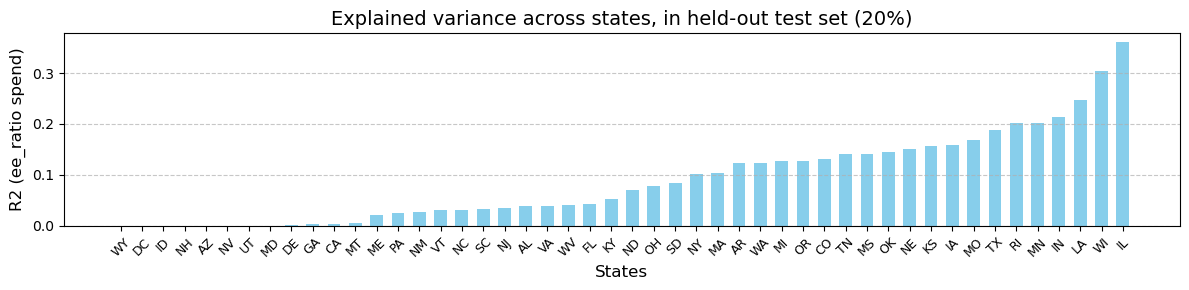

In [52]:
sorted_items = sorted(st_dict.items(), key=lambda item: item[1])
sorted_data = dict(sorted_items)

new_sorted = {}
for k, v in sorted_data.items():
    new_sorted[k] = max(0,v)

# Extract the keys and values
categories = list(new_sorted.keys())
values = list(new_sorted.values())

# Create the plot
plt.figure(figsize=(12, 3))  # Wider figure to accommodate spaced labels

# Create the bar plot
bars = plt.bar(categories, values, color='skyblue', width=0.6)  # Reduced width to create more space


# Set labels with R² for y-axis (using LaTeX notation)
plt.xlabel('States', fontsize=12)
plt.ylabel(f'R2 ({ts_var} spend)', fontsize=12)  # LaTeX notation for R²
plt.title(f'Explained variance across states, in held-out test set (20%)', fontsize=14)


# Increase space between x-axis labels
plt.xticks(rotation=45, ha='center', fontsize=9)
plt.subplots_adjust(bottom=0.2)  # Add more space at the bottom

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

In [54]:
import plotly.graph_objects as go
import pandas as pd

# State coordinates for text labels (approximate centers)
state_coords = {
    'AL': [-86.7916, 32.3617], 'AK': [-149.4937, 64.0685], 'AZ': [-111.4312, 34.2744],
    'AR': [-92.1994, 34.7519], 'CA': [-119.7730, 36.1162], 'CO': [-105.3178, 39.0598],
    'CT': [-72.7273, 41.7658], 'DE': [-75.5277, 39.3185], 'FL': [-81.5158, 27.7663],
    'GA': [-83.2430, 32.1656], 'HI': [-157.8583, 21.0943], 'ID': [-114.7420, 44.2394],
    'IL': [-89.3985, 40.6331], 'IN': [-86.1349, 39.7817], 'IA': [-93.0977, 41.8780],
    'KS': [-96.7265, 38.5816], 'KY': [-84.7700, 37.5726], 'LA': [-91.8259, 30.9843],
    'ME': [-69.7653, 44.6074], 'MD': [-76.7909, 38.9072], 'MA': [-71.5301, 42.2373],
    'MI': [-84.5361, 43.3266], 'MN': [-94.6859, 45.7326], 'MS': [-89.6678, 32.7416],
    'MO': [-92.6043, 38.4623], 'MT': [-110.3626, 46.9219], 'NE': [-99.9018, 41.4925],
    'NV': [-117.0554, 38.4199], 'NH': [-71.5653, 43.4525], 'NJ': [-74.7429, 40.0583],
    'NM': [-106.2485, 34.8405], 'NY': [-74.9481, 42.1657], 'NC': [-78.4687, 35.7596],
    'ND': [-99.7840, 47.4012], 'OH': [-82.7649, 40.3888], 'OK': [-96.9247, 35.5889],
    'OR': [-122.0709, 44.9778], 'PA': [-77.7996, 40.3200], 'RI': [-71.4774, 41.6762],
    'SC': [-80.9056, 33.8361], 'SD': [-99.9018, 44.2853], 'TN': [-86.6876, 35.7449],
    'TX': [-97.5635, 31.1060], 'UT': [-111.8910, 39.3210], 'VT': [-72.8108, 44.0407],
    'VA': [-78.1693, 37.7680], 'WA': [-121.1858, 47.4009], 'WV': [-80.9542, 38.4680],
    'WI': [-89.6165, 44.2563], 'WY': [-107.3025, 42.7475], 'DC': [-77.0369, 38.9072]
}

# Remove the example data - use your actual new_sorted dictionary
# new_sorted = { ... }  # Your actual data goes here

def create_clean_choropleth():
    """Clean version with northeastern legend and percentage formatting"""
    
    df = pd.DataFrame.from_dict(new_sorted, orient='index', columns=['value'])
    df.index.name = 'state'
    df.reset_index(inplace=True)
    
    fig = go.Figure()
    
    # Add choropleth with cleaner styling
    choropleth = go.Choropleth(
        locations=df['state'],
        z=df['value'],
        locationmode='USA-states',
        colorscale='Blues',
        zmin=0,
        zmax=0.35,
        marker_line_color='lightgray',  # Grey state borders
        marker_line_width=1,
        colorbar=dict(
            title="R²", 
            x=0.5,
            y=0.95,
            len=0.7,
            thickness=15,
            orientation="h",
            outlinecolor="rgba(68,68,68,0.5)",
            outlinewidth=1,
            title_font=dict(size=12, color='#333'),
            tickfont=dict(size=10, color='#333'),
            bgcolor='rgba(255,255,255,0.8)'
        ),
        hovertemplate='<b>%{location}</b><br>R² = %{z:.1%}<extra></extra>'  # Percentage in hover
    )
    
    fig.add_trace(choropleth)
    
    # Northeastern states to be handled in legend
    northeast_small = ['CT', 'DE', 'MD', 'MA', 'NH', 'NJ', 'RI', 'VT', 'DC']
    
    # Add labels for non-northeastern states with percentage formatting
    for state, value in new_sorted.items():
        if state in state_coords and state not in northeast_small:
            lon, lat = state_coords[state]
            
            # Format as percentage
            if value == 0:
                text_value = "0.0%"
            else:
                text_value = f"{value*100:.1f}%"
            
            # Show state and percentage
            text = f"{state}<br>{text_value}"
            
            # Dynamic text color with better contrast logic
            if value > 0.12:  # Adjusted threshold
                text_color = "white"
            else:
                text_color = "#333333"
            
            fig.add_trace(go.Scattergeo(
                lon=[lon],
                lat=[lat],
                text=[text],
                mode='text',
                textfont=dict(
                    size=12,  # Increased font size
                    color=text_color,
                    family="Arial"
                ),
                showlegend=False,
                hoverinfo='skip'
            ))
    
    # Add a separate legend/table for northeastern states with percentage formatting
    northeast_text = []
    for state in northeast_small:
        if state in new_sorted:
            value = new_sorted[state]
            if value == 0:
                northeast_text.append(f"{state}: 0.0%")
            else:
                northeast_text.append(f"{state}: {value*100:.1f}%")
    
    # Add text box for northeastern states
    fig.add_annotation(
        x=0.02,
        y=0.98,
        xref="paper",
        yref="paper",
        text="<b>Northeast:</b><br>" + "<br>".join(northeast_text),
        showarrow=False,
        font=dict(size=11, color="#333", family="Arial"),  # Slightly larger font
        bgcolor="rgba(255,255,255,0.95)",
        bordercolor="rgba(68,68,68,0.4)",
        borderwidth=1,
        align="left",
        xanchor="left",
        yanchor="top"
    )
    
    fig.update_geos(
        showframe=True,  # Show map frame
        framecolor="gray",  # Grey outline for overall map
        framewidth=2,
        showcoastlines=True,
        coastlinecolor="gray",  # Grey coastlines
        coastlinewidth=1,
        projection_type='albers usa',
        scope="usa",
        bgcolor='white',  # White background
        showland=False
    )
    
    fig.update_layout(
        title={
            'text': "R² (Mobility Effects During ECE) by State",
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 16, 'color': '#333', 'family': 'Arial'}
        },
        geo=dict(
            showlakes=True,
            lakecolor='white'  # White lakes to match background
        ),
        width=1000,
        height=650,
        margin=dict(l=0, r=0, t=60, b=0),
        paper_bgcolor='white',
        plot_bgcolor='white'
    )
    
    return fig

def create_alternative_with_angular_callouts():
    """Alternative with 60-degree angular callouts that bend to horizontal labels"""
    
    df = pd.DataFrame.from_dict(new_sorted, orient='index', columns=['value'])
    df.index.name = 'state'
    df.reset_index(inplace=True)
    
    fig = go.Figure()
    
    # Add choropleth
    choropleth = go.Choropleth(
        locations=df['state'],
        z=df['value'],
        locationmode='USA-states',
        colorscale='Blues',
        zmin=0,
        zmax=0.35,
        marker_line_color='white',
        marker_line_width=0.5,
        colorbar=dict(
            title="R²", 
            x=0.87,
            y=0.5,
            len=0.7,
            thickness=15,
            orientation="v",
            title_font=dict(size=12, color='#333'),
            tickfont=dict(size=10, color='#333')
        ),
        hovertemplate='<b>%{location}</b><br>R² = %{z:.3f}<extra></extra>'
    )
    
    fig.add_trace(choropleth)
    
    # Calculate 60-degree callouts for northeastern states
    import math
    
    # Function to calculate 60-degree line endpoint
    def calculate_60_degree_point(start_lon, start_lat, length=1.5):
        # 60 degrees = π/3 radians, pointing northeast
        angle = math.pi / 3
        end_lon = start_lon + length * math.cos(angle)
        end_lat = start_lat + length * math.sin(angle)
        return end_lon, end_lat
    
    # Northeastern states with 60-degree callouts
    callout_states = ['CT', 'RI', 'MA', 'NH', 'VT', 'NJ', 'DE', 'MD', 'DC']
    
    # Horizontal label positions (evenly spaced)
    label_positions = {
        'CT': [-62.0, 41.2],
        'RI': [-62.0, 40.6],
        'MA': [-62.0, 42.0],
        'NH': [-62.0, 43.2],
        'VT': [-62.0, 43.8],
        'NJ': [-62.0, 39.8],
        'DE': [-62.0, 39.2],
        'MD': [-62.0, 38.6],
        'DC': [-62.0, 38.0]
    }
    
    # Add labels for all states
    for state, value in new_sorted.items():
        if state in state_coords:
            lon, lat = state_coords[state]
            
            # Format value
            if value == 0:
                text_value = "0.000"
            else:
                text_value = f"{value:.3f}"
            
            if state in callout_states and state in label_positions:
                # Create 60-degree callout with horizontal extension
                
                # Calculate 60-degree endpoint
                bend_lon, bend_lat = calculate_60_degree_point(lon, lat, length=1.5)
                label_lon, label_lat = label_positions[state]
                
                # First line: 60-degree angle from state center
                fig.add_trace(go.Scattergeo(
                    lon=[lon, bend_lon],
                    lat=[lat, bend_lat],
                    mode='lines',
                    line=dict(
                        color='rgba(60,60,60,0.7)',
                        width=1.5
                    ),
                    showlegend=False,
                    hoverinfo='skip'
                ))
                
                # Second line: horizontal to label position
                fig.add_trace(go.Scattergeo(
                    lon=[bend_lon, label_lon],
                    lat=[bend_lat, label_lat],
                    mode='lines',
                    line=dict(
                        color='rgba(60,60,60,0.7)',
                        width=1.5
                    ),
                    showlegend=False,
                    hoverinfo='skip'
                ))
                
                # Add small dot at bend point
                fig.add_trace(go.Scattergeo(
                    lon=[bend_lon],
                    lat=[bend_lat],
                    mode='markers',
                    marker=dict(
                        size=3,
                        color='rgba(60,60,60,0.9)',
                        line=dict(width=0)
                    ),
                    showlegend=False,
                    hoverinfo='skip'
                ))
                
                # Horizontal label
                text = f"{state}: {text_value}"
                fig.add_trace(go.Scattergeo(
                    lon=[label_lon],
                    lat=[label_lat],
                    text=[text],
                    mode='text',
                    textfont=dict(
                        size=10,
                        color="#333333",
                        family="Arial"
                    ),
                    textposition="middle left",
                    showlegend=False,
                    hoverinfo='skip'
                ))
                
            else:
                # Regular states - show both state name and value
                text = f"{state}<br>{text_value}"
                text_color = "white" if value > 0.12 else "#333333"
                
                fig.add_trace(go.Scattergeo(
                    lon=[lon],
                    lat=[lat],
                    text=[text],
                    mode='text',
                    textfont=dict(
                        size=9,
                        color=text_color,
                        family="Arial"
                    ),
                    showlegend=False,
                    hoverinfo='skip'
                ))
    
    fig.update_geos(
        showframe=False,
        showcoastlines=True,
        coastlinecolor="rgba(68,68,68,0.3)",
        projection_type='albers usa',
        scope="usa"
    )
    
    fig.update_layout(
        title={
            'text': "R² (Mobility Effects During ECE) by State",
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 16, 'color': '#333'}
        },
        width=1000,
        height=650,
        margin=dict(l=0, r=0, t=60, b=0),
        paper_bgcolor='white'
    )
    
    return fig

# Choose your preferred version:
fig = create_clean_choropleth()  # Version with northeastern legend box (recommended)

fig.show()
fig.write_image(os.path.join(fig_path,'clean_choropleth_leak_fixed.png'), scale=3)

/tmp/ipykernel_2643288/3856613922.py:344: DeprecationWarning:


Support for Kaleido versions less than 1.0.0 is deprecated and will be removed after September 2025.
Please upgrade Kaleido to version 1.0.0 or greater (`pip install 'kaleido>=1.0.0'` or `pip install 'plotly[kaleido]'`).




=== Moran's I Spatial Autocorrelation Analysis using libpysal ===

1. ADJACENCY-BASED ANALYSIS (Queen Contiguity)
--------------------------------------------------
Moran's I: 0.5232
Expected I: -0.0213
Variance: 0.009795
Z-score: 5.5015
P-value (normal): 3.764958567937286e-08
P-value (randomization): 2.8659263362790144e-08
Significant at α=0.05: True

2. DISTANCE-BASED ANALYSIS (800km threshold)
--------------------------------------------------
Moran's I: -0.0213
Expected I: -0.0213
Variance: -0.000000
Z-score: nan
P-value (normal): nan
P-value (randomization): nan
Significant at α=0.05: False

3. INTERPRETATION
--------------------------------------------------
Result: POSITIVE spatial autocorrelation
Meaning: Similar values cluster together (high near high, low near low)
Statistical significance: highly significant (p < 0.001)
Effect strength: strong

Number of states analyzed: 48
Average number of neighbors: 4.4
Connectivity histogram: {1: 2, 2: 4, 3: 8, 4: 12, 5: 8, 6: 10, 7: 2, 

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/esda/moran.py:251: RuntimeWarning:

invalid value encountered in scalar power

/home/rat884/.conda/envs/test_env/lib/python3.10/site-packages/esda/moran.py:264: RuntimeWarning:

invalid value encountered in scalar power



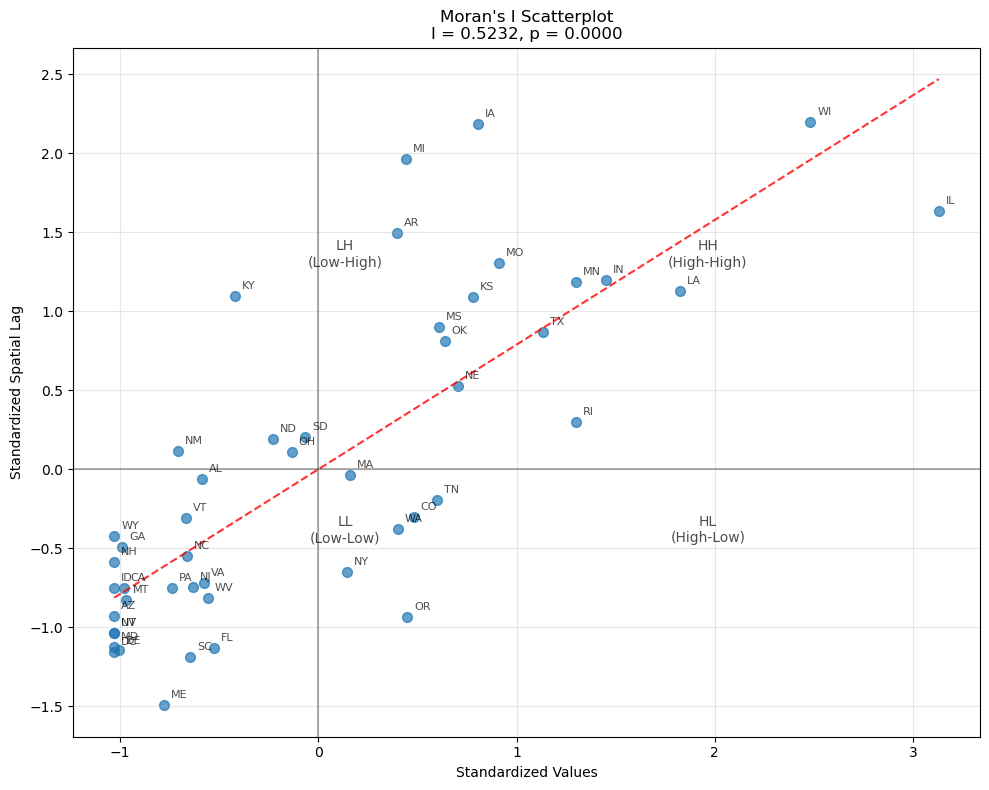

<Figure size 640x480 with 0 Axes>

In [55]:
import pandas as pd
import numpy as np
import libpysal
from esda.moran import Moran
import matplotlib.pyplot as plt
import seaborn as sns

# Your state values
state_values = new_sorted

# Method 1: Using adjacency matrix approach
def create_adjacency_weights():
    """Create weights matrix using state adjacencies"""
    
    # State adjacency relationships (queen contiguity)
    adjacencies = {
        'AL': ['FL', 'GA', 'MS', 'TN'],
        'AZ': ['CA', 'CO', 'NM', 'NV', 'UT'],
        'AR': ['LA', 'MO', 'MS', 'OK', 'TN', 'TX'],
        'CA': ['AZ', 'NV', 'OR'],
        'CO': ['AZ', 'KS', 'NE', 'NM', 'OK', 'UT', 'WY'],
        'CT': ['MA', 'NY', 'RI'],
        'DE': ['MD', 'NJ', 'PA'],
        'FL': ['AL', 'GA'],
        'GA': ['AL', 'FL', 'NC', 'SC', 'TN'],
        'ID': ['MT', 'NV', 'OR', 'UT', 'WA', 'WY'],
        'IL': ['IN', 'IA', 'KY', 'MO', 'WI'],
        'IN': ['IL', 'KY', 'MI', 'OH'],
        'IA': ['IL', 'MN', 'MO', 'NE', 'SD', 'WI'],
        'KS': ['CO', 'MO', 'NE', 'OK'],
        'KY': ['IL', 'IN', 'MO', 'OH', 'TN', 'VA', 'WV'],
        'LA': ['AR', 'MS', 'TX'],
        'ME': ['NH'],
        'MD': ['DE', 'PA', 'VA', 'WV', 'DC'],
        'MA': ['CT', 'NH', 'NY', 'RI', 'VT'],
        'MI': ['IN', 'OH', 'WI'],
        'MN': ['IA', 'ND', 'SD', 'WI'],
        'MS': ['AL', 'AR', 'LA', 'TN'],
        'MO': ['AR', 'IL', 'IA', 'KS', 'KY', 'NE', 'OK', 'TN'],
        'MT': ['ID', 'ND', 'SD', 'WY'],
        'NE': ['CO', 'IA', 'KS', 'MO', 'SD', 'WY'],
        'NV': ['AZ', 'CA', 'ID', 'OR', 'UT'],
        'NH': ['MA', 'ME', 'VT'],
        'NJ': ['DE', 'NY', 'PA'],
        'NM': ['AZ', 'CO', 'OK', 'TX', 'UT'],
        'NY': ['CT', 'MA', 'NJ', 'PA', 'VT'],
        'NC': ['GA', 'SC', 'TN', 'VA'],
        'ND': ['MN', 'MT', 'SD'],
        'OH': ['IN', 'KY', 'MI', 'PA', 'WV'],
        'OK': ['AR', 'CO', 'KS', 'MO', 'NM', 'TX'],
        'OR': ['CA', 'ID', 'NV', 'WA'],
        'PA': ['DE', 'MD', 'NJ', 'NY', 'OH', 'WV'],
        'RI': ['CT', 'MA'],
        'SC': ['GA', 'NC'],
        'SD': ['IA', 'MN', 'MT', 'ND', 'NE', 'WY'],
        'TN': ['AL', 'AR', 'GA', 'KY', 'MO', 'MS', 'NC', 'VA'],
        'TX': ['AR', 'LA', 'NM', 'OK'],
        'UT': ['AZ', 'CO', 'ID', 'NV', 'NM', 'WY'],
        'VT': ['MA', 'NH', 'NY'],
        'VA': ['KY', 'MD', 'NC', 'TN', 'WV', 'DC'],
        'WA': ['ID', 'OR'],
        'WV': ['KY', 'MD', 'OH', 'PA', 'VA'],
        'WI': ['IL', 'IA', 'MI', 'MN'],
        'WY': ['CO', 'ID', 'MT', 'NE', 'SD', 'UT'],
        'DC': ['MD', 'VA']
    }
    
    # Create adjacency dictionary for libpysal
    states = list(state_values.keys())
    # Remove Alaska and Hawaii for contiguity analysis
    continental_states = [s for s in states if s not in ['AK', 'HI']]
    
    adjlist = {}
    for i, state in enumerate(continental_states):
        neighbors = []
        if state in adjacencies:
            for neighbor in adjacencies[state]:
                if neighbor in continental_states:
                    neighbors.append(continental_states.index(neighbor))
        adjlist[i] = neighbors
    
    # Create weights object
    w = libpysal.weights.W(adjlist)
    
    return w, continental_states

# Method 2: Using distance-based weights (alternative approach)
def create_distance_weights():
    """Create distance-based weights using state centroids"""
    
    # Approximate state centroids (longitude, latitude)
    state_centroids = {
        'AL': [-86.79113, 32.377716], 'AZ': [-111.431221, 34.048927], 
        'AR': [-92.131378, 34.751928], 'CA': [-119.766121, 36.116203], 
        'CO': [-105.311104, 39.059811], 'CT': [-72.755371, 41.767], 
        'DE': [-75.526755, 39.161921], 'FL': [-81.686783, 27.766279], 
        'GA': [-83.441162, 32.157435], 'ID': [-114.478828, 44.240459], 
        'IL': [-89.094086, 40.19978], 'IN': [-86.147685, 39.790942], 
        'IA': [-93.620866, 42.032974], 'KS': [-96.726486, 38.572954], 
        'KY': [-84.670067, 37.839333], 'LA': [-91.8271, 30.391830], 
        'ME': [-69.765261, 44.323535], 'MD': [-76.501157, 38.972945], 
        'MA': [-71.530106, 42.230171], 'MI': [-84.536095, 44.182205], 
        'MN': [-94.6859, 46.392410], 'MS': [-89.678696, 32.741646], 
        'MO': [-92.189283, 38.572954], 'MT': [-110.454353, 47.052080], 
        'NE': [-99.901813, 41.492537], 'NV': [-117.055374, 38.854085], 
        'NH': [-71.549709, 43.452492], 'NJ': [-74.756138, 40.221741], 
        'NM': [-106.248482, 34.57992], 'NY': [-74.948051, 42.659829], 
        'NC': [-79.806419, 35.771], 'ND': [-99.784012, 47.448940], 
        'OH': [-82.764915, 40.269789], 'OK': [-96.921387, 35.482309], 
        'OR': [-120.767635, 43.804133], 'PA': [-77.209755, 40.269789], 
        'RI': [-71.422132, 41.82355], 'SC': [-81.035, 33.76], 
        'SD': [-99.901813, 44.426767], 'TN': [-86.580447, 35.860119], 
        'TX': [-97.534994, 31.106], 'UT': [-111.892622, 39.419220], 
        'VT': [-72.710686, 44.26639], 'VA': [-78.169968, 37.54], 
        'WA': [-121.490494, 47.042418], 'WV': [-80.954453, 38.349497], 
        'WI': [-89.616508, 44.269594], 'WY': [-107.30249, 43.075968],
        'DC': [-77.026817, 38.907192]
    }
    
    # Exclude Alaska and Hawaii
    continental_states = [s for s in state_values.keys() if s not in ['AK', 'HI']]
    
    # Create coordinate arrays
    coords = np.array([state_centroids[state] for state in continental_states])
    
    # Create distance-based weights (threshold distance)
    w = libpysal.weights.DistanceBand(coords, threshold=800, binary=True)  # 800 km threshold
    
    return w, continental_states

def perform_morans_i_analysis():
    """Perform comprehensive Moran's I analysis"""
    
    print("=== Moran's I Spatial Autocorrelation Analysis using libpysal ===\n")
    
    # Method 1: Adjacency-based weights
    print("1. ADJACENCY-BASED ANALYSIS (Queen Contiguity)")
    print("-" * 50)
    
    w_adj, continental_states = create_adjacency_weights()
    values_adj = np.array([state_values[state] for state in continental_states])
    
    # Calculate Moran's I
    moran_adj = Moran(values_adj, w_adj)
    
    print(f"Moran's I: {moran_adj.I:.4f}")
    print(f"Expected I: {moran_adj.EI:.4f}")
    print(f"Variance: {moran_adj.VI_norm:.6f}")
    print(f"Z-score: {moran_adj.z_norm:.4f}")
    print(f"P-value (normal): {moran_adj.p_norm}")
    print(f"P-value (randomization): {moran_adj.p_rand}")
    print(f"Significant at α=0.05: {moran_adj.p_norm < 0.05}")
    
    # Method 2: Distance-based weights
    print("\n2. DISTANCE-BASED ANALYSIS (800km threshold)")
    print("-" * 50)
    
    try:
        w_dist, continental_states_dist = create_distance_weights()
        values_dist = np.array([state_values[state] for state in continental_states_dist])
        
        moran_dist = Moran(values_dist, w_dist)
        
        print(f"Moran's I: {moran_dist.I:.4f}")
        print(f"Expected I: {moran_dist.EI:.4f}")
        print(f"Variance: {moran_dist.VI_norm:.6f}")
        print(f"Z-score: {moran_dist.z_norm:.4f}")
        print(f"P-value (normal): {moran_dist.p_norm:.4f}")
        print(f"P-value (randomization): {moran_dist.p_rand:.4f}")
        print(f"Significant at α=0.05: {moran_dist.p_norm < 0.05}")
        
    except Exception as e:
        print(f"Distance-based analysis failed: {e}")
        moran_dist = None
    
    # Interpretation
    print("\n3. INTERPRETATION")
    print("-" * 50)
    
    primary_result = moran_adj  # Use adjacency-based as primary
    
    if primary_result.I > primary_result.EI:
        autocorr_type = "POSITIVE spatial autocorrelation"
        description = "Similar values cluster together (high near high, low near low)"
    elif primary_result.I < primary_result.EI:
        autocorr_type = "NEGATIVE spatial autocorrelation" 
        description = "Dissimilar values cluster together (high near low)"
    else:
        autocorr_type = "NO clear spatial pattern"
        description = "Values appear randomly distributed"
    
    print(f"Result: {autocorr_type}")
    print(f"Meaning: {description}")
    
    if primary_result.p_norm < 0.001:
        significance = "highly significant (p < 0.001)"
    elif primary_result.p_norm < 0.01:
        significance = "very significant (p < 0.01)"
    elif primary_result.p_norm < 0.05:
        significance = "significant (p < 0.05)"
    else:
        significance = "not significant (p ≥ 0.05)"
    
    print(f"Statistical significance: {significance}")
    
    # Effect size interpretation
    abs_i = abs(primary_result.I - primary_result.EI)
    if abs_i > 0.3:
        strength = "strong"
    elif abs_i > 0.1:
        strength = "moderate"
    else:
        strength = "weak"
    
    print(f"Effect strength: {strength}")
    
    # Additional statistics
    print(f"\nNumber of states analyzed: {len(continental_states)}")
    print(f"Average number of neighbors: {w_adj.mean_neighbors:.1f}")
    print(f"Connectivity histogram: {dict(w_adj.histogram)}")
    
    return {
        'adjacency_moran': moran_adj,
        'distance_moran': moran_dist,
        'states': continental_states,
        'values': values_adj
    }

def create_moran_scatterplot(moran_result, states, values):
    """Create Moran scatterplot"""
    
    # Calculate spatial lag
    w = moran_result.w
    y = values
    spatial_lag = libpysal.weights.lag_spatial(w, y)
    
    # Standardize values
    y_std = (y - np.mean(y)) / np.std(y)
    lag_std = (spatial_lag - np.mean(spatial_lag)) / np.std(spatial_lag)
    
    # Create plot
    plt.figure(figsize=(10, 8))
    
    # Scatter plot
    plt.scatter(y_std, lag_std, alpha=0.7, s=50)
    
    # Add state labels
    for i, state in enumerate(states):
        plt.annotate(state, (y_std[i], lag_std[i]), 
                    xytext=(5, 5), textcoords='offset points', 
                    fontsize=8, alpha=0.7)
    
    # Add regression line
    z = np.polyfit(y_std, lag_std, 1)
    p = np.poly1d(z)
    plt.plot(y_std, p(y_std), "r--", alpha=0.8)
    
    # Add quadrant lines
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
    
    # Labels and title
    plt.xlabel('Standardized Values')
    plt.ylabel('Standardized Spatial Lag')
    plt.title(f"Moran's I Scatterplot\nI = {moran_result.I:.4f}, p = {moran_result.p_norm:.4f}")
    
    # Add quadrant labels
    plt.text(0.7, 0.7, 'HH\n(High-High)', transform=plt.gca().transAxes, 
             ha='center', va='center', fontsize=10, alpha=0.7)
    plt.text(0.3, 0.7, 'LH\n(Low-High)', transform=plt.gca().transAxes, 
             ha='center', va='center', fontsize=10, alpha=0.7)
    plt.text(0.3, 0.3, 'LL\n(Low-Low)', transform=plt.gca().transAxes, 
             ha='center', va='center', fontsize=10, alpha=0.7)
    plt.text(0.7, 0.3, 'HL\n(High-Low)', transform=plt.gca().transAxes, 
             ha='center', va='center', fontsize=10, alpha=0.7)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Run the analysis
if __name__ == "__main__":
    results = perform_morans_i_analysis()
    
    # Create Moran scatterplot
    print("\n4. MORAN SCATTERPLOT")
    print("-" * 50)
    print("Generating Moran scatterplot...")
    
    create_moran_scatterplot(results['adjacency_moran'], 
                           results['states'], 
                           results['values'])
    plt.savefig(os.path.join(fig_path, 'morans_I_scatter.png'), dpi=300)